# Saskatoon Wastewater Treatment Plant Biogas Production Modelling

In [ ]:
# Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

# XGBoost and Machine Learning Libraries
import xgboost as xgb
from xgboost import XGBRegressor, DMatrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

# Bayesian Optimization
from bayes_opt import BayesianOptimization

# SHAP for interpretability
import shap

# Statistical Tests
from scipy.stats import pearsonr, shapiro, normaltest



# 1: Scenario 1: Input Variables of FS and TWAS Quantity Data

## 1.1: Biogas Modelling and Optimization 

In [42]:
#Data Import

Biogas=pd.read_excel(r"C:\Kerry Work\BioGas\CSCE 2023\Paper\SaskatoonWWTP_Digester_Input_Data_2018_2022_2.xlsx"
                   ,sheet_name="BiogasFlow")

Inflows=pd.read_excel(r"C:\Kerry Work\BioGas\CSCE 2023\Paper\SaskatoonWWTP_Digester_Input_Data_2018_2022_2.xlsx"
                   ,sheet_name="DigesterInflow")


In [43]:
X=pd.DataFrame(Inflows)
X.drop(['Total Digester Inflow (m3/day)'],axis=1, inplace=True) #Delete Last column that I do not need
X.dropna(axis=1,inplace=True) #Remove Last columns from dataset
X=X.drop([0]).reset_index(drop=True) #Remove a row and reindex

X = X.rename(columns={'Unnamed: 0':'Date','DailyAverageTWASFlowtoDigesters_L/s':'TWAS',
                       'DailyAverageFSFlow_L/s':'FS','Daily_Total_Primary_Sludge_to_Digesters_m3':'PS'}) #Rename columns
X['TWAS'] = X['TWAS'].astype(float)
X['FS'] = X['FS'].astype(float)
X['PS'] = X['PS'].astype(float)

y=pd.DataFrame(Biogas)
columns_to_keep = ['Date', 'DailyAverageBiogasFlowfromDigesters_m3permin']
# Using the loc accessor
y = y.loc[:, columns_to_keep]
# Alternatively, directly reassign the DataFrame with the desired columns
y = y[columns_to_keep]
y = y.rename(columns={'DailyAverageBiogasFlowfromDigesters_m3permin': 'Biogas'})

X_Sc = pd.merge(X, y, on='Date', how='inner')
X_Sc.drop(['PS', 'Date'],axis=1, inplace=True) #Delete Last column that I do not need
X_Sc=X_Sc[['FS', 'TWAS', 'Biogas']]


,FS,TWAS,Biogas
0,6.973584,3.841542,5.128537
1,6.947068,5.709966,5.148443
2,6.904708,10.796041,5.230320
3,7.000851,4.958014,5.559699
4,6.902504,7.837946,7.386836
...,...,...,...
1690,3.992277,7.987613,10.221583
1691,4.004428,7.805668,9.527673
1692,3.938877,8.268775,10.294615
1693,4.166596,8.175488,10.990092


In [44]:
# Function to remove outliers using IQR method for a specific column
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the upper and lower bounds for outlier removal
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify and remove outliers for the specified column
    outliers_iqr = data[(data[column] < lower_bound) | (data[column] > upper_bound)]

    # Remove outliers
    data = data.drop(outliers_iqr.index)
    
    return data

# Apply the function for each column
columns_to_remove_outliers = ['Biogas', 'FS', 'TWAS']

for column in columns_to_remove_outliers:
    X_Sc = remove_outliers_iqr(X_Sc, column)

# Optionally, reset the index after removing outliers
X_Sc = X_Sc.reset_index(drop=True)



FS        float64
TWAS      float64
Biogas    float64
dtype: object

In [177]:
####  Model Testing and Training
X_Sc = X_Sc.astype(float)
### TO Check if there are NULL variables

null_counts = X_Sc.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

# Drop additional columns and assign to new variables X1 and y
X1 = X_Sc.drop(['Biogas'], axis=1)
y = X_Sc.drop(['FS','TWAS'], axis=1)

#Split data into train and test sets

test_size=0.25
random_seed = 42  # You can choose any integer as the seed
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=test_size, random_state=random_seed)

In [178]:
#Model Development

regressor = xgb.XGBRegressor(max_depth=10, learning_rate=0.5, n_estimators=600,subsample= 1,gamma=3)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
rmse_test= np.sqrt(mean_squared_error(y_test, y_pred))

print (rmse_test)

1.505442188911384


In [179]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {'objective':['reg:squarederror'],'booster':['gbtree'],
'learning_rate': [0.1,0.15,0.2,0.3,0.35, 0.4,0.5],'max_depth': [3,5,7,10],
'min_child_weight': [10,15,20,25],'colsample_bytree': [0.8, 0.9, 1],
'n_estimators': [100,200,300,400,500],"reg_alpha" : [0.5,0.2,1],
"reg_lambda" : [2,3,5],"gamma" : [3]}
grid_xgb = RandomizedSearchCV(regressor,parameters, cv=5, n_iter=10, scoring='neg_mean_absolute_error', verbose=3, n_jobs=12)

grid_xgb.fit(X_train, y_train, verbose = 1)

# Accessing detailed results
cv_results_df = pd.DataFrame(grid_xgb.cv_results_)

# Extracting standard deviation of RMSE for each fold
std_rmse = cv_results_df[['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].std(axis=1)

# Extracting correlation coefficients (assuming you want Pearson correlation)
correlation_coef = cv_results_df[['param_learning_rate', 'param_max_depth', 'param_min_child_weight', 'param_colsample_bytree', 'param_n_estimators']].corr()

# Print the results
print("Standard Deviation of RMSE for each fold:")
print(std_rmse)

print("\nCorrelation Coefficients:")
print(correlation_coef)

y_pred = grid_xgb.predict(X_test)
rmse_test= np.sqrt(mean_squared_error(y_test, y_pred))


print(grid_xgb.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Standard Deviation of RMSE for each fold:
0    0.053542
1    0.049097
2    0.067527
3    0.064537
4    0.069536
5    0.065654
6    0.063766
7    0.059990
8    0.058542
9    0.062250
dtype: float64

Correlation Coefficients:
Empty DataFrame
Columns: []
Index: []
{'reg_lambda': 5, 'reg_alpha': 0.2, 'objective': 'reg:squarederror', 'n_estimators': 300, 'min_child_weight': 20, 'max_depth': 5, 'learning_rate': 0.15, 'gamma': 3, 'colsample_bytree': 1, 'booster': 'gbtree'}


C:\Programs\Anaconda3\TEMP\ipykernel_10084\2146001964.py:19: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_coef = cv_results_df[['param_learning_rate', 'param_max_depth', 'param_min_child_weight', 'param_colsample_bytree', 'param_n_estimators']].corr()


In [209]:
#Model Development

# Model Development
regressor = xgb.XGBRegressor(max_depth=20, learning_rate=0.4, n_estimators=500, subsample=1, gamma=2, reg_alpha= 0.1)
regressor.fit(X_train, y_train)

# Predictions
y_test_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)

# Ensure the shapes of y_test and y_pred are 1-dimensional
y_test = np.ravel(y_test)
y_train = np.ravel(y_train)
y_test_pred = np.ravel(y_test_pred)
y_train_pred = np.ravel(y_train_pred)

# Calculate RMSE for both train and test sets
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Calculate the Pearson correlation coefficient
correlation_test, _ = pearsonr(y_test, y_test_pred)
correlation_train, _ = pearsonr(y_train, y_train_pred)

# Print the results
print("RMSE Test:", rmse_test)
print("RMSE Train:", rmse_train)
print("Test Pearson Correlation Coefficient:", correlation_test)
print("Train Pearson Correlation Coefficient:", correlation_train)

RMSE Test: 1.4577037004827464
RMSE Train: 0.7141669989597093
Test Pearson Correlation Coefficient: 0.45755553071940036
Train Pearson Correlation Coefficient: 0.9197857166729584


In [211]:
# Define the cross-validation method
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store scores
train_rmse_scores = []
test_rmse_scores = []
train_r2_scores = []
test_r2_scores = []

# Define your regressor
#regressor = XGBRegressor(random_state=42)

# Assuming X1 and y are properly defined as DataFrame and Series respectively
for train_index, test_index in cv.split(X1):
    X_train11, X_test11 = X1.iloc[train_index], X1.iloc[test_index]
    y_train11, y_test11 = y[train_index], y[test_index]
    

    
    # Predict on training and test data
    y_train_pred = regressor.predict(X_train11)
    y_test_pred = regressor.predict(X_test11)
    
    # Calculate RMSE for training and test data
    train_rmse = np.sqrt(mean_squared_error(y_train11, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test11, y_test_pred))
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    
    # Calculate R^2 for training and test data
    train_r2 = r2_score(y_train11, y_train_pred)
    test_r2 = r2_score(y_test11, y_test_pred)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Print training and testing RMSE and R^2 scores
print(f'Training RMSE scores: {train_rmse_scores}')
print(f'Testing RMSE scores: {test_rmse_scores}')
print(f'Mean Training RMSE: {np.mean(train_rmse_scores)}')
print(f'Mean Testing RMSE: {np.mean(test_rmse_scores)}')
print(f'Training R^2 scores: {train_r2_scores}')
print(f'Testing R^2 scores: {test_r2_scores}')
print(f'Mean Training R^2: {np.mean(train_r2_scores)}')
print(f'Mean Testing R^2: {np.mean(test_r2_scores)}')

Training RMSE scores: [0.8508479936356159, 0.9571510535271599, 1.0479252295573875, 1.0608772847829606, 1.0552413759662826]
Testing RMSE scores: [1.4418494544260476, 1.145490534730552, 0.7643451092914718, 0.6890426712654504, 0.7228885943645829]
Mean Training RMSE: 0.9944085874938813
Mean Testing RMSE: 0.9527232728156209
Training R^2 scores: [0.725448535952348, 0.6581301394605619, 0.5699042869548367, 0.5767000956362238, 0.5716222976672545]
Testing R^2 scores: [0.19437189431634905, 0.4538866583854396, 0.7997801710146857, 0.8085849723838089, 0.806104581666309]
Mean Training R^2: 0.620361071134245
Mean Testing R^2: 0.6125456555533184


In [213]:
# Save data, model, and results
import pickle
with open('Scenario1_Biogas.pkl', 'wb') as f:
    pickle.dump({
        'X1': X1,
        'y': y,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'regressor': regressor,
        'rmse_test': rmse_test,
        'rmse_train': rmse_train,
        'correlation_test': correlation_test,
        'correlation_train': correlation_train,
        'train_rmse_scores': train_rmse_scores,
        'test_rmse_scores': test_rmse_scores,
        'train_r2_scores': train_r2_scores,
        'test_r2_scores': test_r2_scores
    }, f)

print("Data and model configuration saved successfully.")


################### Load data, model, and results
#with open('Scenario1_Biogas.pkl', 'rb') as f:
    #data = pickle.load(f)


Data and model configuration saved successfully.


C:\Programs\Anaconda3\TEMP\ipykernel_10084\73876805.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


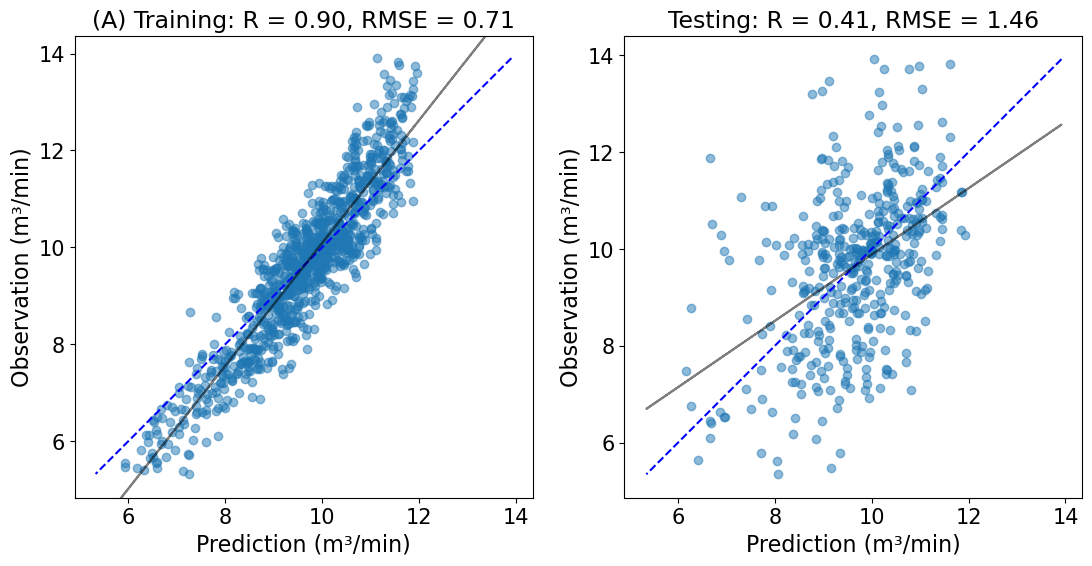

In [215]:
##PLot the results
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)

# Calculate RMSE and R^2 values for training data
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r_train = np.sqrt(r2_score(y_train, y_train_pred))

# Calculate RMSE and R^2 values for testing data
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r_test = np.sqrt(r2_score(y_test, y_pred))


##############   FIGURE  VISUALISATION  ##################
fig, (ax2,ax1)=plt.subplots(1,2,figsize=(13, 6),sharex=True)

ax2.scatter(y_train_pred, y_train, alpha = 0.5)

p1 = max(max(y_train_pred), np.max(y_train))
p2 = min(min(y_train_pred), np.min(y_train))
ax2.plot([p1,p2], [p1, p2], 'b--')


m2, b2 = np.polyfit(y_train_pred, y_train, 1)
ax2.plot(y_train, m2 * y_train + b2, color='k',linestyle='-', alpha = 0.5)

ax2.set_xlabel('Prediction (m\u00b3/min)', fontsize=16)
ax2.set_ylabel('Observation (m\u00b3/min)', fontsize=16)
ax2.axis('equal')
ax2.set_title(f'(A) Training: R = {r_train:.2f}, RMSE = {rmse_train:.2f}' ,fontsize=17)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)


ax1.scatter(y_pred, y_test,alpha = 0.5)
p1 = max(max(y_pred), np.max(y_test))
p2 = min(min(y_pred), np.min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b--')

m1, b1 = np.polyfit(y_pred, y_test, 1)
ax1.plot(y_test, m1 * y_test + b1, color='k',linestyle='-', alpha = 0.5)

ax1.set_xlabel('Prediction (m\u00b3/min)', fontsize=16)
ax1.set_ylabel('Observation (m\u00b3/min)', fontsize=16)
ax1.axis('equal')
ax1.set_title(f'Testing: R = {r_test:.2f}, RMSE = {rmse_test:.2f}' ,fontsize=17)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)




fig.show()



C:\Programs\Anaconda3\TEMP\ipykernel_10084\3167385060.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


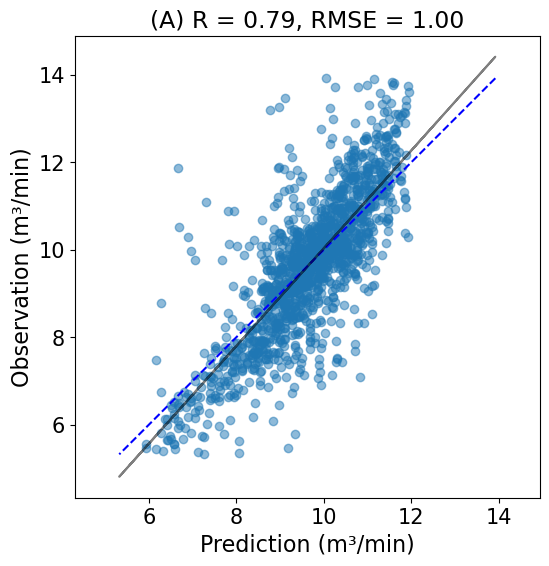

In [216]:
##PLot the results
y_pred_total = regressor.predict(X1)


# Calculate RMSE and R^2 values for training data
rmse_total = np.sqrt(mean_squared_error(y, y_pred_total))
r_total = np.sqrt(r2_score(y, y_pred_total))



##############   FIGURE  VISUALISATION  ##################
fig, (ax2)=plt.subplots(figsize=(6, 6),sharex=True)

ax2.scatter(y_pred_total, y, alpha = 0.5)

p1 = max(max(y_pred_total), np.max(y))
p2 = min(min(y_pred_total), np.min(y))
ax2.plot([p1,p2], [p1, p2], 'b--')


m2, b2 = np.polyfit(y_pred_total, y, 1)
ax2.plot(y, m2 * y + b2, color='k',linestyle='-', alpha = 0.5)

ax2.set_xlabel('Prediction (m\u00b3/min)', fontsize=16)
ax2.set_ylabel('Observation (m\u00b3/min)', fontsize=16)
ax2.axis('equal')
ax2.set_title(f'(A) R = {r_total:.2f}, RMSE = {rmse_total:.2f}' ,fontsize=17)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

fig.show()



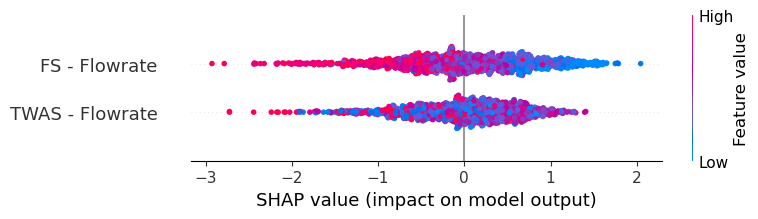

<Figure size 640x480 with 0 Axes>

In [329]:
# SHAP Analysis
import shap
custom_feature_names = ["FS - Flowrate",  "TWAS - Flowrate"]  # Replace with your actual feature names


explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X1)

# Summary plot
shap.summary_plot(shap_values, X1, feature_names=custom_feature_names)
plt.savefig('shap_summary_plot.png', dpi=1000, bbox_inches='tight')

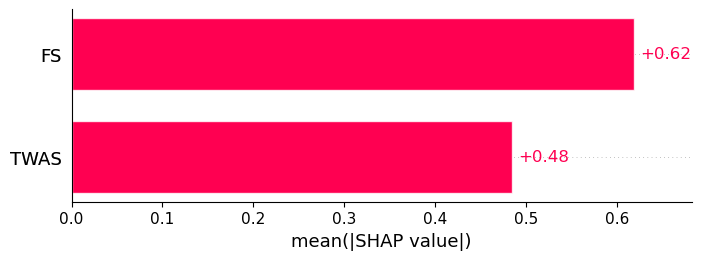

In [330]:
# Create the TreeExplainer and compute SHAP values
explainer = shap.Explainer(regressor)
shap_values = explainer(X1)

# Now shap_values is an Explanation object, which can be directly used with plotting functions
shap.plots.bar(shap_values)

## 1.2: BAYESIAN Optimization for Mixing Ratio

In [334]:
def predict_xgboost(FS, TWAS):
    # Load the pre-trained XGBoost model
    ###xgb_model = xgb.Booster()
    ###xgb_model.load_model("xgboost.model")
    
    # Prepare the input data for the model
    data = pd.DataFrame({'FS': FS,
                      'TWAS': TWAS}, index=[0])
    
    
    input_data = xgb.DMatrix(data)
    
    # Make the prediction
    prediction = regressor.predict(data)[0]#(input_data)[0]
    
    return prediction

pbounds = {'FS': (0.53,8.94),'TWAS': (2.4,11.03)}
optimizer = BayesianOptimization(f=predict_xgboost, pbounds=pbounds)
# Optimize the black box function
optimizer.maximize(init_points=5,n_iter=1500)

results_df = pd.DataFrame(optimizer.res, columns=['params', 'target'])
print(optimizer.max)
#print("Maximum:", optimizer.res['max']['max_val'])
#print("Optimal parameters:", optimizer.res['max']['max_params'])


# Optimization results in a dataframe

results_df_df = pd.DataFrame(optimizer.res, columns=['params', 'target'])



def extract_params(params_dict):
    x = params_dict['FS']
    y = params_dict['TWAS']

    return x, y

# Apply the extract_params function to the 'params' column
results_df_df[['FS', 'TWAS']] = results_df_df['params'].apply(extract_params).apply(pd.Series)

# Drop the 'params' column
results_df_df.drop('params', axis=1, inplace=True)

results_df_df

|   iter    |  target   |    FS     |   TWAS    |
-------------------------------------------------
| 1         | 9.548     | 4.23      | 4.006     |
| 2         | 7.899     | 7.122     | 7.662     |
| 3         | 9.304     | 5.707     | 5.126     |
| 4         | 7.812     | 6.465     | 3.683     |
| 5         | 11.34     | 1.469     | 5.132     |
| 6         | 10.12     | 2.384     | 6.465     |
| 7         | 10.5      | 0.53      | 3.811     |
| 8         | 10.15     | 0.53      | 6.105     |
| 9         | 10.57     | 2.163     | 3.974     |
| 10        | 10.84     | 0.53      | 11.03     |
| 11        | 10.84     | 2.692     | 11.03     |
| 12        | 10.84     | 1.54      | 9.425     |
| 13        | 6.829     | 4.999     | 11.03     |
| 14        | 9.915     | 8.94      | 11.03     |
| 15        | 10.84     | 1.653     | 11.03     |
| 16        | 10.84     | 0.5332    | 8.577     |
| 17        | 11.85     | 1.394     | 2.402     |
| 18        | 11.85     | 2.661     | 2.4       |


| 100       | 8.448     | 6.316     | 8.012     |
| 101       | 11.85     | 2.026     | 2.551     |
| 102       | 11.85     | 0.8005    | 2.413     |
| 103       | 11.85     | 0.6646    | 2.458     |
| 104       | 11.85     | 0.8756    | 2.534     |
| 105       | 11.68     | 0.7363    | 2.615     |
| 106       | 11.85     | 2.691     | 2.548     |
| 107       | 10.42     | 4.088     | 6.541     |
| 108       | 11.85     | 2.852     | 2.447     |
| 109       | 11.68     | 2.876     | 2.596     |
| 110       | 11.85     | 1.256     | 2.506     |
| 111       | 11.34     | 1.475     | 5.121     |
| 112       | 11.85     | 1.127     | 2.412     |
| 113       | 11.85     | 1.005     | 2.581     |
| 114       | 11.5      | 0.8893    | 2.726     |
| 115       | 10.52     | 5.936     | 5.619     |
| 116       | 9.915     | 8.224     | 9.153     |
| 117       | 10.93     | 4.567     | 4.206     |
| 118       | 11.5      | 1.145     | 2.663     |
| 119       | 11.85     | 1.859     | 2.577     |


| 200       | 10.9      | 3.535     | 3.317     |
| 201       | 10.5      | 1.68      | 5.427     |
| 202       | 11.17     | 1.018     | 3.291     |
| 203       | 10.9      | 0.6236    | 3.34      |
| 204       | 11.17     | 1.271     | 3.101     |
| 205       | 10.54     | 1.314     | 3.439     |
| 206       | 9.393     | 4.611     | 8.267     |
| 207       | 8.307     | 4.695     | 7.731     |
| 208       | 10.76     | 4.179     | 7.953     |
| 209       | 10.15     | 3.108     | 6.202     |
| 210       | 11.03     | 3.964     | 8.768     |
| 211       | 11.17     | 2.032     | 3.135     |
| 212       | 11.17     | 1.753     | 3.254     |
| 213       | 10.54     | 2.021     | 3.432     |
| 214       | 9.663     | 4.901     | 4.402     |
| 215       | 11.13     | 3.949     | 3.042     |
| 216       | 10.84     | 3.262     | 9.1       |
| 217       | 11.85     | 2.431     | 2.513     |
| 218       | 10.64     | 3.844     | 5.013     |
| 219       | 10.84     | 1.122     | 9.78      |


| 300       | 9.137     | 7.618     | 8.289     |
| 301       | 9.568     | 4.456     | 6.859     |
| 302       | 8.36      | 7.149     | 8.239     |
| 303       | 10.15     | 1.452     | 6.194     |
| 304       | 10.84     | 2.941     | 9.085     |
| 305       | 10.84     | 1.872     | 9.287     |
| 306       | 10.84     | 0.53      | 8.932     |
| 307       | 9.783     | 8.94      | 5.321     |
| 308       | 10.84     | 3.448     | 8.827     |
| 309       | 8.795     | 6.652     | 10.14     |
| 310       | 6.924     | 8.12      | 2.4       |
| 311       | 8.516     | 6.541     | 4.4       |
| 312       | 8.989     | 1.613     | 7.836     |
| 313       | 10.84     | 2.18      | 8.243     |
| 314       | 11.34     | 3.516     | 5.231     |
| 315       | 10.5      | 3.637     | 5.452     |
| 316       | 11.34     | 3.274     | 5.137     |
| 317       | 10.5      | 3.016     | 5.288     |
| 318       | 10.84     | 2.322     | 9.222     |
| 319       | 10.84     | 1.641     | 8.682     |


| 400       | 10.44     | 8.668     | 6.165     |
| 401       | 10.57     | 2.6       | 3.955     |
| 402       | 10.84     | 0.5364    | 9.351     |
| 403       | 11.41     | 3.601     | 5.866     |
| 404       | 6.794     | 6.447     | 6.635     |
| 405       | 9.155     | 6.827     | 5.756     |
| 406       | 8.675     | 6.905     | 10.68     |
| 407       | 10.84     | 3.312     | 9.723     |
| 408       | 10.84     | 0.982     | 8.542     |
| 409       | 10.54     | 3.684     | 3.646     |
| 410       | 5.365     | 4.888     | 10.29     |
| 411       | 10.59     | 4.322     | 10.66     |
| 412       | 10.12     | 1.067     | 6.474     |
| 413       | 10.08     | 0.9877    | 7.213     |
| 414       | 10.99     | 6.162     | 4.995     |
| 415       | 9.865     | 5.996     | 4.765     |
| 416       | 9.952     | 3.83      | 5.945     |
| 417       | 10.26     | 4.179     | 8.563     |
| 418       | 10.04     | 3.687     | 6.564     |
| 419       | 10.54     | 1.663     | 3.524     |


| 500       | 8.651     | 4.782     | 6.018     |
| 501       | 10.93     | 2.393     | 5.829     |
| 502       | 9.47      | 8.864     | 6.8       |
| 503       | 10.53     | 0.8384    | 5.66      |
| 504       | 11.17     | 2.994     | 3.142     |
| 505       | 10.84     | 2.446     | 8.713     |
| 506       | 9.915     | 8.62      | 10.77     |
| 507       | 9.915     | 8.423     | 9.47      |
| 508       | 11.34     | 2.381     | 5.149     |
| 509       | 10.84     | 2.506     | 9.025     |
| 510       | 10.44     | 8.15      | 6.429     |
| 511       | 11.54     | 5.505     | 4.652     |
| 512       | 9.667     | 5.683     | 4.594     |
| 513       | 9.366     | 5.32      | 4.598     |
| 514       | 10.92     | 5.525     | 4.787     |
| 515       | 11.17     | 1.776     | 3.065     |
| 516       | 8.524     | 6.157     | 10.25     |
| 517       | 8.989     | 0.53      | 7.833     |
| 518       | 11.28     | 2.352     | 3.725     |
| 519       | 10.5      | 1.938     | 3.722     |


| 600       | 7.659     | 5.791     | 2.4       |
| 601       | 10.79     | 5.217     | 2.748     |
| 602       | 10.5      | 5.01      | 2.402     |
| 603       | 10.12     | 2.794     | 6.374     |
| 604       | 11.17     | 2.211     | 3.226     |
| 605       | 11.31     | 4.658     | 2.4       |
| 606       | 10.15     | 1.312     | 5.945     |
| 607       | 11.46     | 2.491     | 4.56      |
| 608       | 8.858     | 8.904     | 3.712     |
| 609       | 10.09     | 8.94      | 7.423     |
| 610       | 10.07     | 4.072     | 6.848     |
| 611       | 9.929     | 3.325     | 6.535     |
| 612       | 7.387     | 7.44      | 6.919     |
| 613       | 10.13     | 8.94      | 4.972     |
| 614       | 9.346     | 6.213     | 6.326     |
| 615       | 10.09     | 8.104     | 7.157     |
| 616       | 10.12     | 2.004     | 6.481     |
| 617       | 10.84     | 0.8463    | 9.762     |
| 618       | 10.68     | 3.303     | 4.961     |
| 619       | 11.01     | 3.681     | 5.719     |


| 700       | 9.879     | 7.154     | 4.633     |
| 701       | 6.8       | 7.647     | 2.831     |
| 702       | 10.84     | 1.845     | 11.02     |
| 703       | 10.88     | 4.065     | 4.731     |
| 704       | 9.241     | 6.348     | 5.58      |
| 705       | 10.84     | 3.501     | 8.261     |
| 706       | 10.25     | 4.932     | 2.853     |
| 707       | 11.65     | 2.648     | 4.366     |
| 708       | 10.26     | 4.21      | 9.782     |
| 709       | 9.755     | 1.902     | 4.42      |
| 710       | 11.46     | 1.846     | 4.668     |
| 711       | 4.962     | 5.376     | 9.269     |
| 712       | 7.854     | 7.471     | 8.772     |
| 713       | 11.46     | 2.022     | 4.649     |
| 714       | 11.65     | 1.757     | 4.233     |
| 715       | 11.15     | 1.978     | 4.212     |
| 716       | 10.3      | 8.94      | 5.634     |
| 717       | 10.84     | 2.813     | 10.85     |
| 718       | 10.59     | 4.276     | 9.569     |
| 719       | 8.876     | 6.123     | 4.241     |


| 800       | 11.85     | 1.915     | 2.484     |
| 801       | 11.17     | 3.134     | 3.102     |
| 802       | 11.85     | 2.958     | 2.495     |
| 803       | 10.08     | 3.599     | 7.04      |
| 804       | 10.84     | 3.559     | 7.878     |
| 805       | 11.65     | 1.638     | 4.322     |
| 806       | 10.84     | 3.151     | 9.302     |
| 807       | 10.08     | 1.323     | 6.928     |
| 808       | 11.85     | 2.66      | 2.426     |
| 809       | 11.85     | 2.563     | 2.417     |
| 810       | 10.54     | 1.105     | 3.516     |
| 811       | 11.5      | 1.959     | 2.65      |
| 812       | 11.85     | 1.76      | 2.509     |
| 813       | 10.54     | 1.456     | 3.672     |
| 814       | 11.5      | 2.163     | 2.677     |
| 815       | 11.85     | 1.379     | 2.506     |
| 816       | 10.95     | 3.671     | 8.063     |
| 817       | 11.17     | 1.958     | 2.934     |
| 818       | 10.5      | 2.36      | 3.889     |
| 819       | 10.76     | 3.817     | 9.899     |


| 900       | 11.68     | 3.246     | 2.606     |
| 901       | 10.12     | 0.53      | 6.81      |
| 902       | 10.84     | 1.182     | 10.65     |
| 903       | 9.915     | 8.94      | 9.696     |
| 904       | 10.84     | 3.444     | 9.886     |
| 905       | 10.59     | 4.414     | 10.14     |
| 906       | 11.85     | 0.6348    | 2.4       |
| 907       | 11.85     | 2.045     | 2.4       |
| 908       | 11.85     | 2.197     | 2.4       |
| 909       | 10.84     | 0.9259    | 10.3      |
| 910       | 10.84     | 3.048     | 8.003     |
| 911       | 8.675     | 6.69      | 9.31      |
| 912       | 10.84     | 2.853     | 9.753     |
| 913       | 10.84     | 0.6313    | 9.99      |
| 914       | 10.84     | 1.567     | 8.899     |
| 915       | 11.85     | 2.769     | 2.4       |
| 916       | 11.04     | 1.308     | 2.788     |
| 917       | 11.34     | 3.401     | 5.127     |
| 918       | 7.778     | 7.023     | 6.586     |
| 919       | 9.414     | 6.135     | 5.112     |


| 1000      | 10.5      | 3.121     | 3.779     |
| 1001      | 11.17     | 3.073     | 3.296     |
| 1002      | 11.65     | 3.127     | 4.219     |
| 1003      | 11.46     | 3.296     | 4.442     |
| 1004      | 11.01     | 3.24      | 4.079     |
| 1005      | 11.46     | 3.195     | 4.481     |
| 1006      | 11.56     | 3.333     | 4.17      |
| 1007      | 8.071     | 5.848     | 3.479     |
| 1008      | 6.265     | 5.287     | 9.945     |
| 1009      | 11.65     | 3.388     | 4.308     |
| 1010      | 9.385     | 4.436     | 3.72      |
| 1011      | 8.318     | 6.048     | 8.02      |
| 1012      | 11.28     | 3.459     | 3.734     |
| 1013      | 6.175     | 5.984     | 8.982     |
| 1014      | 8.524     | 6.164     | 9.825     |
| 1015      | 10.54     | 3.507     | 3.553     |
| 1016      | 10.08     | 1.579     | 7.415     |
| 1017      | 8.36      | 7.012     | 10.04     |
| 1018      | 6.783     | 6.796     | 2.4       |
| 1019      | 10.14     | 7.881     | 6.424     |


| 1100      | 9.346     | 8.006     | 4.17      |
| 1101      | 11.68     | 1.556     | 2.594     |
| 1102      | 11.53     | 1.049     | 4.738     |
| 1103      | 11.85     | 1.584     | 2.493     |
| 1104      | 11.68     | 2.076     | 2.605     |
| 1105      | 8.25      | 7.087     | 5.934     |
| 1106      | 9.915     | 8.264     | 10.27     |
| 1107      | 10.84     | 1.56      | 10.65     |
| 1108      | 10.76     | 3.848     | 8.688     |
| 1109      | 10.84     | 1.92      | 8.975     |
| 1110      | 10.84     | 3.591     | 8.654     |
| 1111      | 10.84     | 1.444     | 8.676     |
| 1112      | 10.84     | 1.25      | 10.13     |
| 1113      | 10.89     | 4.049     | 10.81     |
| 1114      | 10.08     | 3.29      | 7.082     |
| 1115      | 9.915     | 8.704     | 7.956     |
| 1116      | 11.85     | 1.044     | 2.4       |
| 1117      | 10.12     | 4.01      | 4.923     |
| 1118      | 8.36      | 7.036     | 11.03     |
| 1119      | 7.614     | 6.777     | 2.716     |


| 1200      | 11.34     | 2.105     | 5.231     |
| 1201      | 10.5      | 3.346     | 3.787     |
| 1202      | 11.85     | 1.194     | 2.474     |
| 1203      | 11.4      | 4.009     | 8.01      |
| 1204      | 10.84     | 2.083     | 8.417     |
| 1205      | 10.9      | 4.743     | 4.221     |
| 1206      | 11.92     | 3.973     | 2.405     |
| 1207      | 10.84     | 3.529     | 9.742     |
| 1208      | 11.85     | 2.49      | 2.4       |
| 1209      | 10.84     | 1.615     | 10.05     |
| 1210      | 11.85     | 1.456     | 2.581     |
| 1211      | 11.85     | 2.741     | 2.479     |
| 1212      | 10.12     | 5.527     | 4.496     |
| 1213      | 11.53     | 3.295     | 4.719     |
| 1214      | 10.12     | 0.8029    | 6.547     |
| 1215      | 10.5      | 1.713     | 3.713     |
| 1216      | 7.387     | 6.312     | 6.822     |
| 1217      | 11.65     | 1.246     | 4.317     |
| 1218      | 10.84     | 3.362     | 9.235     |
| 1219      | 11.78     | 4.033     | 2.588     |


| 1300      | 11.34     | 3.184     | 5.23      |
| 1301      | 9.207     | 7.169     | 3.93      |
| 1302      | 9.17      | 7.073     | 4.353     |
| 1303      | 10.84     | 1.957     | 9.498     |
| 1304      | 10.84     | 1.129     | 8.568     |
| 1305      | 10.5      | 0.53      | 5.44      |
| 1306      | 9.137     | 7.758     | 10.81     |
| 1307      | 10.84     | 1.785     | 8.831     |
| 1308      | 11.28     | 1.039     | 3.762     |
| 1309      | 9.845     | 4.715     | 4.528     |
| 1310      | 11.04     | 3.562     | 2.801     |
| 1311      | 10.45     | 4.078     | 3.79      |
| 1312      | 9.307     | 6.957     | 4.136     |
| 1313      | 8.391     | 4.883     | 6.944     |
| 1314      | 10.84     | 2.64      | 8.439     |
| 1315      | 9.665     | 4.638     | 6.616     |
| 1316      | 8.795     | 6.57      | 10.0      |
| 1317      | 10.84     | 2.735     | 8.113     |
| 1318      | 7.807     | 6.746     | 3.287     |
| 1319      | 10.76     | 3.984     | 9.478     |


| 1400      | 11.5      | 2.869     | 2.717     |
| 1401      | 11.17     | 1.679     | 3.141     |
| 1402      | 10.08     | 0.53      | 7.283     |
| 1403      | 10.76     | 2.271     | 5.049     |
| 1404      | 10.84     | 2.799     | 8.699     |
| 1405      | 11.34     | 2.981     | 5.193     |
| 1406      | 10.08     | 1.854     | 7.571     |
| 1407      | 10.42     | 4.02      | 6.577     |
| 1408      | 10.15     | 2.042     | 6.172     |
| 1409      | 10.62     | 5.415     | 4.749     |
| 1410      | 8.647     | 5.759     | 4.874     |
| 1411      | 10.46     | 2.152     | 4.809     |
| 1412      | 11.01     | 2.71      | 4.087     |
| 1413      | 10.5      | 3.629     | 5.287     |
| 1414      | 10.84     | 2.461     | 8.015     |
| 1415      | 10.84     | 3.658     | 8.512     |
| 1416      | 10.84     | 2.829     | 8.93      |
| 1417      | 11.34     | 3.374     | 5.245     |
| 1418      | 10.09     | 8.384     | 7.588     |
| 1419      | 10.34     | 4.269     | 6.671     |


| 1500      | 11.03     | 3.963     | 8.895     |
| 1501      | 10.15     | 1.178     | 6.297     |
| 1502      | 11.66     | 4.331     | 4.178     |
| 1503      | 11.17     | 1.278     | 2.961     |
| 1504      | 10.84     | 2.524     | 9.882     |
| 1505      | 11.65     | 2.443     | 4.237     |
{'target': 11.949177742004395, 'params': {'FS': 4.416999658074095, 'TWAS': 4.341442731476744}}


,target,FS,TWAS
0,9.548383,4.230485,4.005624
1,7.899398,7.122385,7.661591
2,9.303874,5.707432,5.125580
3,7.811629,6.465441,3.682851
4,11.337908,1.469079,5.131806
...,...,...,...
1500,10.145445,1.178434,6.296948
1501,11.657642,4.331472,4.178436
1502,11.170748,1.278376,2.960575
1503,10.841509,2.524235,9.882088


In [383]:
# Save the optimizer, model, and results DataFrame
with open('optimizer_model_results_Biogas_MixingRatio_Scenario1_v2.pkl', 'wb') as f:
    pickle.dump((optimizer, regressor, results_df), f)

#### Visualizatoin of optimization results

In [349]:
####    DAtaframe for the biogas production rates above 10 m^3/min

## A dataframe with Biogas > 10
new_results_df_df = results_df_df[results_df_df['target'] > 9.5]
new_results_df_df.reset_index(drop=True,inplace = True)

new_results_df_df

# add new columns to new dataframe
new_results_df_df = new_results_df_df.assign(FS_percent =new_results_df_df['FS']/(new_results_df_df['TWAS']+
                                       new_results_df_df['FS']),
                                       TWAS_percent =new_results_df_df['TWAS']/(new_results_df_df['TWAS']+
                                       new_results_df_df['FS']))
new_results_df_df = new_results_df_df.assign(FS_to_TWAS =new_results_df_df['FS']/(new_results_df_df['TWAS']))


new_results_df_df ###Mixing ratios




,target,FS,TWAS,FS_percent,TWAS_percent,FS_to_TWAS
0,9.548383,4.230485,4.005624,0.513651,0.486349,1.056136
1,11.337908,1.469079,5.131806,0.222558,0.777442,0.286269
2,10.118980,2.383526,6.465195,0.269364,0.730636,0.368670
3,10.496107,0.530000,3.811211,0.122086,0.877914,0.139063
4,10.145445,0.530000,6.105438,0.079874,0.920126,0.086808
...,...,...,...,...,...,...
1295,10.145445,1.178434,6.296948,0.157642,0.842358,0.187144
1296,11.657642,4.331472,4.178436,0.508992,0.491008,1.036625
1297,11.170748,1.278376,2.960575,0.301578,0.698422,0.431800
1298,10.841509,2.524235,9.882088,0.203464,0.796536,0.255435


In [350]:
new_results_df_df.describe()

,target,FS,TWAS,FS_percent,TWAS_percent,FS_to_TWAS
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,10.854738,3.182428,6.174141,0.338830,0.661170,0.613583
std,0.573891,2.079407,2.704013,0.157479,0.157479,0.440470
min,9.506075,0.530000,2.400000,0.045848,0.308328,0.048051
25%,10.499584,1.679416,4.071828,0.213663,0.531718,0.271720
50%,10.841509,2.820382,5.631502,0.321004,0.678996,0.472763
75%,11.272428,3.991522,8.682187,0.468282,0.786337,0.880696
max,11.949178,8.940000,11.030000,0.691672,0.954152,2.243302


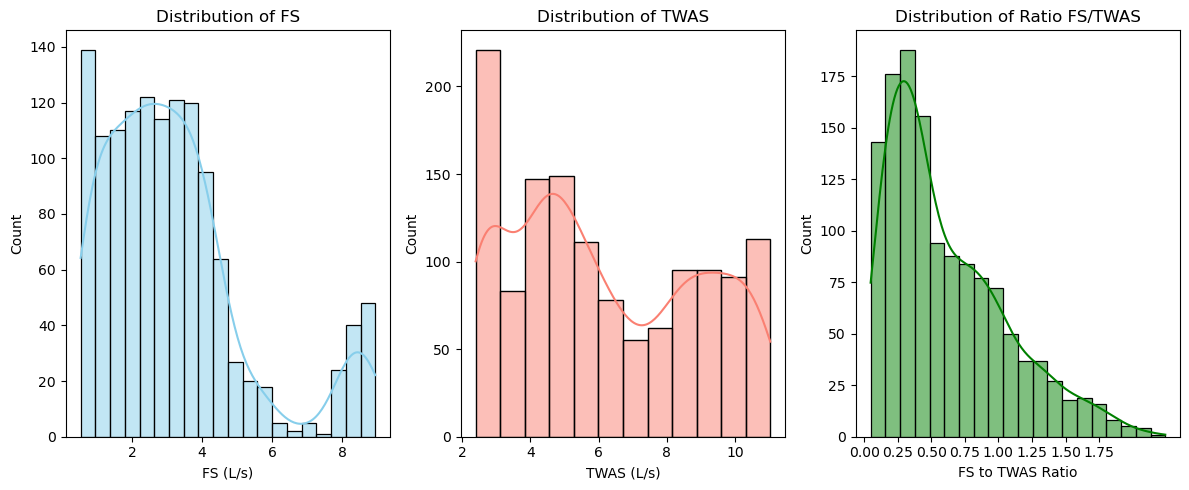

In [351]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.histplot(new_results_df_df['FS'], kde=True, color='skyblue')
plt.title('Distribution of FS')
plt.xlabel('FS (L/s)')


plt.subplot(1, 3, 2)
sns.histplot(new_results_df_df['TWAS'], kde=True, color='salmon')
plt.title('Distribution of TWAS')
plt.xlabel('TWAS (L/s)')


plt.subplot(1, 3, 3)
sns.histplot(new_results_df_df['FS_to_TWAS'], kde=True, color='green')
plt.title('Distribution of Ratio FS/TWAS')
plt.xlabel('FS to TWAS Ratio')
plt.xticks(np.arange(0, 2, 0.25))

plt.tight_layout()
plt.show()

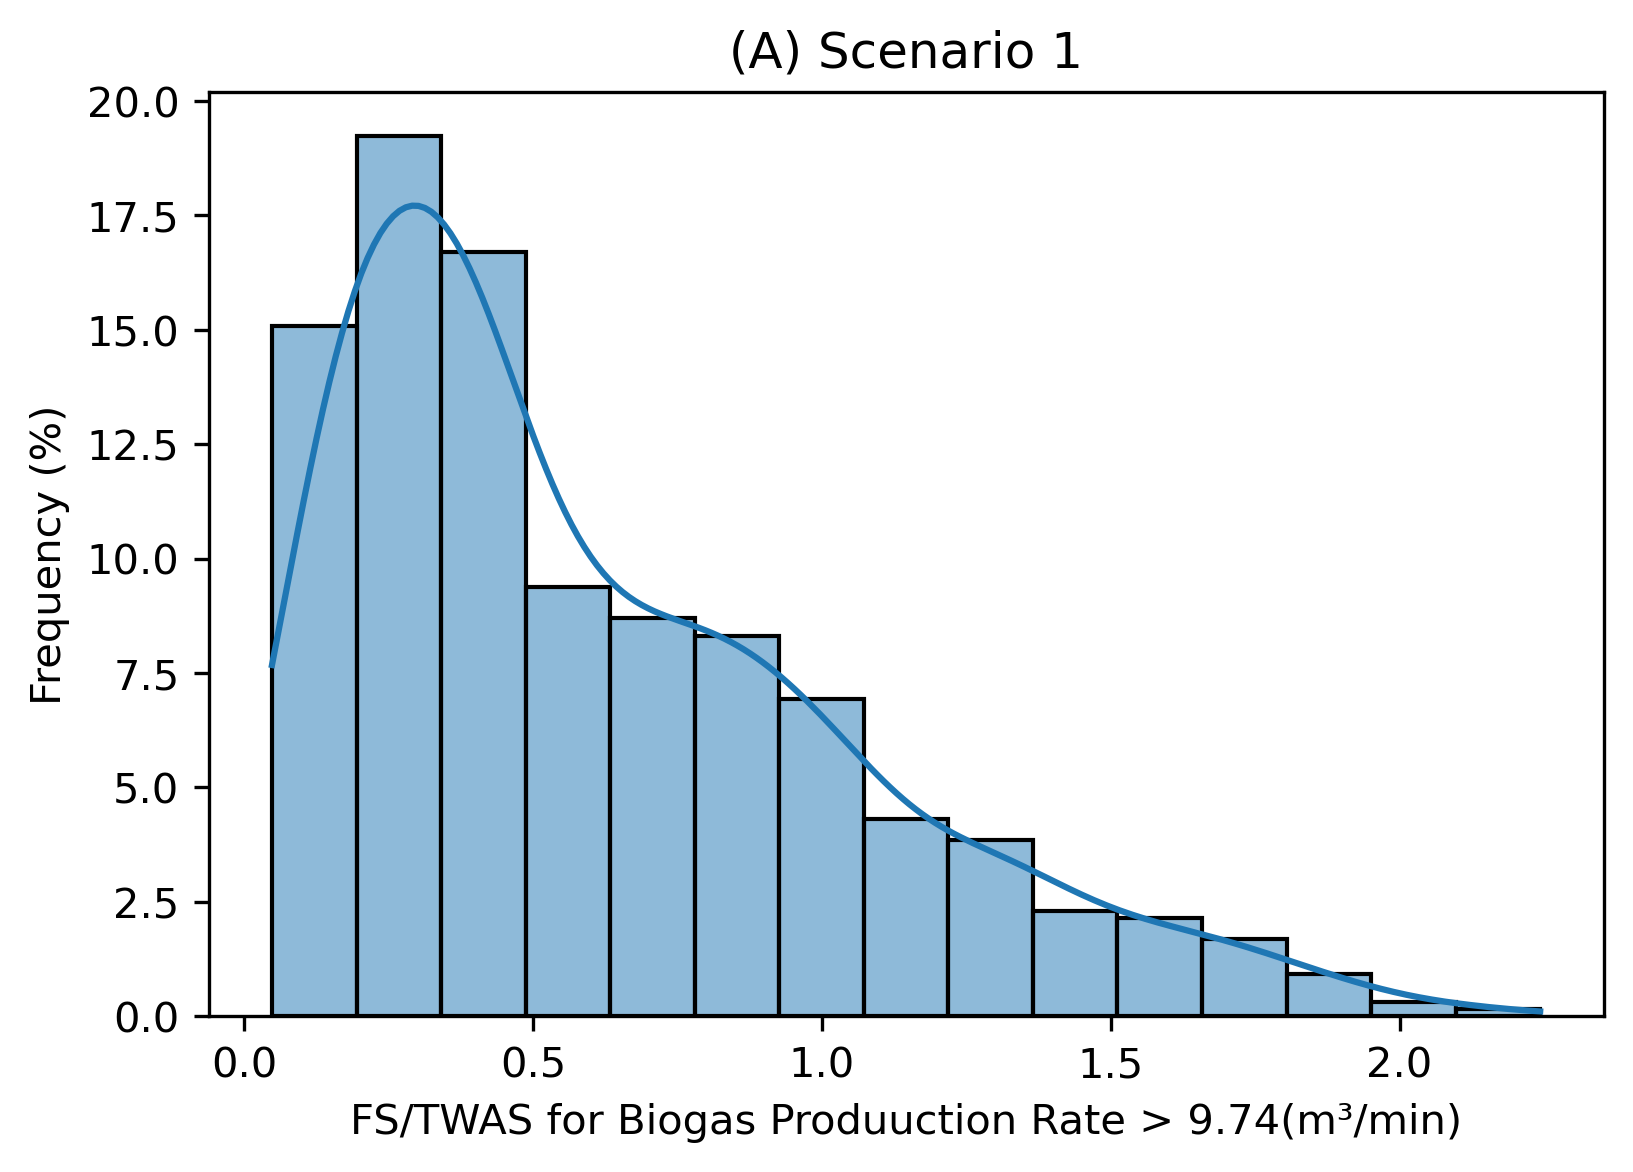

In [356]:
# Plot the histogram
# Increase figure size and set higher DPI
plt.figure(figsize=(6, 4), dpi=300)
sns.histplot(new_results_df_df['FS_to_TWAS'], bins=15, kde=True,  stat='percent')
plt.title('(A) Scenario 1')
plt.xlabel('FS/TWAS for Biogas Produuction Rate > 9.74(m\u00b3/min)')
plt.ylabel('Frequency (%)')
plt.grid(False)
plt.show()

# 2: Scenario 2: Input Variables of FS and TWAS Quality and Quantity Data

## 2.1: Biogas Modelling and Optimization 

In [221]:
FS=pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\BioGas\CSCE 2023\Paper\SaskatoonWWTP_Digester_Input_Data_2018_2022_November_2023_USE.xlsx"
                   ,sheet_name="FS_Quality")
TWAS=pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\BioGas\CSCE 2023\Paper\SaskatoonWWTP_Digester_Input_Data_2018_2022_November_2023_USE.xlsx"
                   ,sheet_name="TWAS_Quality")

Biogas=pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\BioGas\CSCE 2023\Paper\SaskatoonWWTP_Digester_Input_Data_2018_2022_November_2023_USE.xlsx"
                   ,sheet_name="BiogasFlow")
Biogas_flow=Biogas[['TimeStamp','DailyAverageBiogasFlowfromDigesters_m3permin']]


Sludge_flow=pd.read_excel(r"C:\Users\moa997\OneDrive - University of Saskatchewan\Kerry Work\BioGas\CSCE 2023\Paper\SaskatoonWWTP_Digester_Input_Data_2018_2022_November_2023_USE.xlsx"
                   ,sheet_name="DigesterInflow")
FS_flow=Sludge_flow[['TimeStamp','DailyAverageFSFlow_L/s']]
TWAS_flow=Sludge_flow[['TimeStamp','DailyAverageTWASFlowtoDigesters_L/s']]

In [223]:
# Function to remove outliers using IQR method for a specific column
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the upper and lower bounds for outlier removal
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify and remove outliers for the specified column
    outliers_iqr = data[(data[column] < lower_bound) | (data[column] > upper_bound)]

    # Remove outliers
    data = data.drop(outliers_iqr.index)
    
    return data

# Apply the function for each column
columns_to_remove_outliers = ['pH @ 25°C', 'Phosphorus, Total', 'Solids, Fixed','Solids, Total','Solids, Volatile',
                              'Temperature']


for column in columns_to_remove_outliers:
    FS = remove_outliers_iqr(FS, column)

# Optionally, reset the index after removing outliers
FS = FS.reset_index(drop=True)


FS.describe()


,pH @ 25°C,"Phosphorus, Total","Solids, Fixed","Solids, Total","Solids, Volatile",Temperature
count,384.000000,361.000000,384.000000,384.000000,384.000000,384.000000
mean,5.824740,78.917105,1.653190,6.027578,4.373112,16.939583
std,0.400114,33.711136,0.513922,1.234500,0.855301,2.549919
min,4.750000,13.475000,0.590000,3.065000,2.275000,10.000000
25%,5.500000,49.400000,1.290000,5.236250,3.850000,14.987500
50%,5.900000,76.150000,1.582500,5.970000,4.347500,17.100000
75%,6.150000,105.000000,1.945000,6.895000,4.916250,19.200000
max,6.650000,185.500000,3.015000,9.325000,6.420000,22.700000


In [224]:
# Apply the function for each column
columns_to_remove_outliers = [ 'Phosphorus, Total', 'Solids, Fixed','Solids, Total','Solids, Volatile']


for column in columns_to_remove_outliers:
    TWAS = remove_outliers_iqr(TWAS, column)

# Optionally, reset the index after removing outliers
TWAS = TWAS.reset_index(drop=True)
TWAS.describe()

,"Phosphorus, Total","Solids, Fixed","Solids, Total","Solids, Volatile"
count,115.000000,127.000000,127.000000,127.000000
mean,1040.217391,1.084646,3.447795,2.358583
std,180.468240,0.302730,0.375941,0.445358
min,627.000000,0.610000,2.700000,1.490000
25%,927.500000,0.860000,3.145000,1.995000
50%,1040.000000,1.010000,3.400000,2.300000
75%,1140.000000,1.280000,3.700000,2.705000
max,1450.000000,1.900000,4.370000,3.290000


In [226]:
FS1 = FS.copy()
FS1 = FS1.drop('Phosphorus, Total', axis=1)
FS1 = FS1.dropna()

TWAS1 = TWAS.copy()
TWAS1 = TWAS1.drop('Phosphorus, Total', axis=1)
TWAS1 = TWAS1.dropna()



In [227]:
## NORMALITY TEST for FS
columns_to_check_FS = ['pH @ 25°C','Solids, Fixed','Solids, Total','Solids, Volatile','Temperature']
for column in columns_to_check_FS:
    #Shapiro-Wilk test
    stat,p=shapiro(FS1[column])
    print (f"FS Shapiro-Wilk Test for {column}- p-value:",p)

FS Shapiro-Wilk Test for pH @ 25°C- p-value: 1.4414415545616066e-06
FS Shapiro-Wilk Test for Solids, Fixed- p-value: 1.361013573841774e-06
FS Shapiro-Wilk Test for Solids, Total- p-value: 0.24575743079185486
FS Shapiro-Wilk Test for Solids, Volatile- p-value: 0.0416426919400692
FS Shapiro-Wilk Test for Temperature- p-value: 5.295276878314326e-06


If the p-value < 0.05 in the Shapiro-Wilk test, it suggests that the data significantly deviates from a normal distribution.
Therefore non-normal values are pH, VS, FS, and temperature.


In [228]:
## NORMALITY TEST for TWAS
columns_to_check_TWAS = ['Solids, Fixed','Solids, Total','Solids, Volatile']
for column in columns_to_check_TWAS:
    #Shapiro-Wilk test
    stat,p=shapiro(TWAS1[column])
    print (f"TWAS Shapiro-Wilk Test for {column}- p-value:",p)

TWAS Shapiro-Wilk Test for Solids, Fixed- p-value: 5.062566924607381e-05
TWAS Shapiro-Wilk Test for Solids, Total- p-value: 0.017154783010482788
TWAS Shapiro-Wilk Test for Solids, Volatile- p-value: 0.008220060728490353


Therefore non-normal values are FS, VS, TS, and temperature

In [229]:
  
### CORRELATION TEST  ###

## Function for SPERMAN Correlation 
def spearman_correlation (dataframe):
    r, pval = stats.spearmanr(dataframe,axis=0)
    return r, pval

####  FS   ####
r, pval = spearman_correlation(FS1[columns_to_check_FS]) 

# Create DataFrames for correlation coefficients and p-values
correlation_results_FS = pd.DataFrame(data=r, columns=columns_to_check_FS, index=columns_to_check_FS)
pvalue_results_FS = pd.DataFrame(data=pval, columns=columns_to_check_FS, index=columns_to_check_FS)

# Print the combined results
print("FS Spearman correlation:")
print (correlation_results_FS)
print ("")
print ("")
print("FS Spearman P-Values:")
print (pvalue_results_FS)

FS Spearman correlation:
                  pH @ 25°C  Solids, Fixed  Solids, Total  Solids, Volatile  \
pH @ 25°C          1.000000      -0.304056      -0.312224         -0.270321   
Solids, Fixed     -0.304056       1.000000       0.828996          0.600794   
Solids, Total     -0.312224       0.828996       1.000000          0.935962   
Solids, Volatile  -0.270321       0.600794       0.935962          1.000000   
Temperature       -0.374436       0.048243       0.052877          0.036873   

                  Temperature  
pH @ 25°C           -0.374436  
Solids, Fixed        0.048243  
Solids, Total        0.052877  
Solids, Volatile     0.036873  
Temperature          1.000000  


FS Spearman P-Values:
                     pH @ 25°C  Solids, Fixed  Solids, Total  \
pH @ 25°C         0.000000e+00   1.299167e-09   4.403368e-10   
Solids, Fixed     1.299167e-09   0.000000e+00   6.084054e-98   
Solids, Total     4.403368e-10   6.084054e-98   0.000000e+00   
Solids, Volatile  8.037507e-

In [230]:
### CORRELATION TEST  ###
TWAS1 = TWAS1.dropna()

####  TWAS   ####
r, pval = spearman_correlation(TWAS[columns_to_check_TWAS]) 

# Create DataFrames for correlation coefficients and p-values
correlation_results_TWAS = pd.DataFrame(data=r, columns=columns_to_check_TWAS, index=columns_to_check_TWAS)
pvalue_results_TWAS = pd.DataFrame(data=pval, columns=columns_to_check_TWAS, index=columns_to_check_TWAS)

# Print the combined results
print("TWAS Spearman P-Values:")
correlation_results_TWAS

TWAS Spearman P-Values:


,"Solids, Fixed","Solids, Total","Solids, Volatile"
"Solids, Fixed",1.000000,0.186844,-0.532927
"Solids, Total",0.186844,1.000000,0.693129
"Solids, Volatile",-0.532927,0.693129,1.000000


In [231]:
TWAS1

,Row Labels,"Solids, Fixed","Solids, Total","Solids, Volatile"
0,2018-05-15 08:10:00,0.75,3.03,2.27
1,2018-05-22 09:30:00,0.94,3.04,2.10
2,2018-05-29 07:45:00,0.75,3.10,2.35
3,2018-06-05 08:00:00,0.93,3.24,2.31
4,2018-06-12 07:30:00,1.48,3.76,2.28
...,...,...,...,...
122,2022-03-15 07:50:00,0.85,3.47,2.62
123,2022-03-22 08:50:00,0.74,3.04,2.29
124,2022-03-29 08:20:00,0.80,3.00,2.00
125,2022-04-05 07:30:00,1.00,3.00,2.00


### 2.2.1: Input Variables 

In [232]:
FS1_1 = FS1.copy()
TWAS1_1 = TWAS1.copy()

TWAS1_1

,Row Labels,"Solids, Fixed","Solids, Total","Solids, Volatile"
0,2018-05-15 08:10:00,0.75,3.03,2.27
1,2018-05-22 09:30:00,0.94,3.04,2.10
2,2018-05-29 07:45:00,0.75,3.10,2.35
3,2018-06-05 08:00:00,0.93,3.24,2.31
4,2018-06-12 07:30:00,1.48,3.76,2.28
...,...,...,...,...
122,2022-03-15 07:50:00,0.85,3.47,2.62
123,2022-03-22 08:50:00,0.74,3.04,2.29
124,2022-03-29 08:20:00,0.80,3.00,2.00
125,2022-04-05 07:30:00,1.00,3.00,2.00


In [233]:
###  "_FS" to specific columns
columns_to_rename = {'Row Labels':'Date','pH @ 25°C': 'pH_FS', 'Phosphorus, Total': 'P_FS','Solids, Volatile':'VS_FS',
                     'Temperature':'T_FS'}
FS1_1.rename(columns=columns_to_rename, inplace=True)

columns_to_remove = ['Solids, Fixed', 'Solids, Total']
FS1_1.drop(columns=columns_to_remove, inplace=True)

# Extract only the date part (removing the time portion) from 'Date' column in FS1_1 DataFrame
FS1_1['Date'] = FS1_1['Date'].dt.date
FS1_1['Date'] = pd.to_datetime(FS1_1['Date'])


columns_to_rename = {'TimeStamp':'Date','DailyAverageFSFlow_L/s': 'FS_flow'}
FS_flow.rename(columns=columns_to_rename, inplace=True)
FS_flow['Date'] = pd.to_datetime(FS_flow['Date'])



C:\Programs\Anaconda3\TEMP\ipykernel_10084\2472462338.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FS_flow.rename(columns=columns_to_rename, inplace=True)
C:\Programs\Anaconda3\TEMP\ipykernel_10084\2472462338.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FS_flow['Date'] = pd.to_datetime(FS_flow['Date'])


## 

In [234]:
###  "_TWAS" to specific columns
columns_to_rename = {'Row Labels':'Date', 'Phosphorus, Total': 'P_TWAS','Solids, Volatile':'VS_TWAS'}
TWAS1_1.rename(columns=columns_to_rename, inplace=True)

columns_to_remove = ['Solids, Fixed', 'Solids, Total']
TWAS1_1.drop(columns=columns_to_remove, inplace=True)

# Extract only the date part (removing the time portion) from 'Date' column in FS1_1 DataFrame
TWAS1_1['Date'] = TWAS1_1['Date'].dt.date
TWAS1_1['Date'] = pd.to_datetime(TWAS1_1['Date'])


columns_to_rename = {'TimeStamp':'Date','DailyAverageTWASFlowtoDigesters_L/s': 'TWAS_flow'}
TWAS_flow.rename(columns=columns_to_rename, inplace=True)
TWAS_flow['Date'] = pd.to_datetime(TWAS_flow['Date'])
TWAS_flow

C:\Programs\Anaconda3\TEMP\ipykernel_10084\1012401161.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TWAS_flow.rename(columns=columns_to_rename, inplace=True)
C:\Programs\Anaconda3\TEMP\ipykernel_10084\1012401161.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TWAS_flow['Date'] = pd.to_datetime(TWAS_flow['Date'])


,Date,TWAS_flow
0,2018-01-01,4.199359
1,2018-01-02,5.880536
2,2018-01-03,10.008985
3,2018-01-04,7.860823
4,2018-01-05,6.111122
...,...,...
1820,2022-12-26,7.987613
1821,2022-12-27,7.805668
1822,2022-12-28,8.268775
1823,2022-12-29,8.175488


In [235]:
###  "_BIOGAS" to specific columns
columns_to_rename = {'TimeStamp':'Date', 'DailyAverageBiogasFlowfromDigesters_m3permin': 'Biogas_flow'}
Biogas_flow.rename(columns=columns_to_rename, inplace=True)


# Extract only the date part (removing the time portion) from 'Date' column in FS1_1 DataFrame
Biogas_flow['Date'] = Biogas_flow['Date'].dt.date
Biogas_flow['Date'] = pd.to_datetime(Biogas_flow['Date'])

Biogas_flow


C:\Programs\Anaconda3\TEMP\ipykernel_10084\4131825282.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Biogas_flow.rename(columns=columns_to_rename, inplace=True)
C:\Programs\Anaconda3\TEMP\ipykernel_10084\4131825282.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Biogas_flow['Date'] = Biogas_flow['Date'].dt.date
C:\Programs\Anaconda3\TEMP\ipykernel_10084\4131825282.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,Date,Biogas_flow
0,2018-01-01,7.986412
1,2018-01-02,8.084565
2,2018-01-03,9.246957
3,2018-01-04,9.503207
4,2018-01-05,9.407059
...,...,...
1820,2022-12-26,10.221583
1821,2022-12-27,9.527673
1822,2022-12-28,10.294615
1823,2022-12-29,10.990092


In [236]:
merged_FS = pd.merge(FS1_1,FS_flow, on='Date', how='inner')
merged_FS.drop_duplicates(subset='Date', keep='first', inplace=True)


merged_TWAS = pd.merge(TWAS1_1,TWAS_flow, on='Date', how='inner')
merged_TWAS.drop_duplicates(subset='Date', keep='first', inplace=True)

# First, merge merged_TWAS and merged_FS based on 'Date'
merged_temp = pd.merge(merged_TWAS, merged_FS, on='Date', how='inner')
# Then, merge the result with Biogas_flow based on 'Date'
merged_Biogas = pd.merge(merged_temp, Biogas_flow, on='Date', how='inner')

## 2.3: Recursive Feature Elimination using XGBoost

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [244]:
X = merged_Biogas.iloc[:, 1:9]  # Columns 2, 3, 4, and 5
y = merged_Biogas.iloc[:, -1]   # Last column

# Specify features to be kept constant
constant_features = ['TWAS_flow', 'FS_flow','Biogas_flow']  # Replace 'Feature1' and 'Feature2' with your actual feature names

# Exclude constant features from the feature set
X = X.drop(columns=constant_features)



# Initialize XGBoost model
xgb_model = XGBRegressor()

# Specify the number of features to select (you can adjust this based on your preference)
num_features_to_select = 3  # Adjust the number of features you want to select

# Perform RFE on the training data
rfe = RFE(estimator=xgb_model, n_features_to_select=num_features_to_select)
rfe.fit(X, y)  # Use X_train and y_train for feature selection

# Get the selected features
selected_features = X.columns[rfe.support_]

# Evaluate model performance using cross-validation on the training data
scores = cross_val_score(estimator=xgb_model, X=X[selected_features], y=y, cv=5)  # Adjust the number of cross-validation folds as needed

# Print the selected features and their cross-validation scores
print("Selected Features:", selected_features)
print("Cross-Validation Scores:", scores)

# After selecting features and evaluating model performance, you can proceed to train and test your model on the test data (X_test, y_test).
# You can use the selected features for training and testing.

Selected Features: Index(['pH_FS', 'VS_FS', 'T_FS'], dtype='object')
Cross-Validation Scores: [-3.72981789 -2.20860273 -0.73854592 -2.99475635 -1.54068349]


Recursive Feature Elimination was used and indicated in addition to FS and TWAS inflow rates, I can use VS_TWAS and pH_FS, respectively. 

In [251]:
######    ######   ######   #######   # ######    #######
FS1_2 = FS.copy()
columns_to_rename = {'Row Labels':'Date','pH @ 25°C': 'pH_FS', 'Phosphorus, Total': 'P_FS','Solids, Volatile':'VS_FS',
                     'Temperature':'T_FS'}
FS1_2.rename(columns=columns_to_rename, inplace=True)

columns_to_remove = ['Solids, Fixed', 'Solids, Total','P_FS']
FS1_2.drop(columns=columns_to_remove, inplace=True)

# Extract only the date part (removing the time portion) from 'Date' column in FS1_1 DataFrame
FS1_2['Date'] = FS1_2['Date'].dt.date
FS1_2['Date'] = pd.to_datetime(FS1_2['Date'])



###  "_TWAS" to specific columns ################   #####################   #####################
TWAS1_2 = TWAS.copy()
columns_to_rename = {'Row Labels':'Date', 'Phosphorus, Total': 'P_TWAS','Solids, Volatile':'VS_TWAS'}
TWAS1_2.rename(columns=columns_to_rename, inplace=True)

columns_to_remove = ['Solids, Fixed', 'Solids, Total','P_TWAS']
TWAS1_2.drop(columns=columns_to_remove, inplace=True)

# Extract only the date part (removing the time portion) from 'Date' column in FS1_1 DataFrame
TWAS1_2['Date'] = TWAS1_2['Date'].dt.date
TWAS1_2['Date'] = pd.to_datetime(TWAS1_2['Date'])


In [254]:
merged_FS1_2 = pd.merge(FS1_2,FS_flow, on='Date', how='inner')
merged_FS1_2.drop_duplicates(subset='Date', keep='first', inplace=True)


#merged_TWAS1_2 = pd.merge(TWAS1_2,TWAS_flow, on='Date', how='inner')
merged_TWAS1_2 = TWAS_flow
merged_TWAS1_2.drop_duplicates(subset='Date', keep='first', inplace=True)

# First, merge merged_TWAS and merged_FS based on 'Date'
merged_temp1_2 = pd.merge(merged_TWAS1_2, merged_FS1_2, on='Date', how='inner')
# Then, merge the result with Biogas_flow based on 'Date'
merged_Biogas1_2 = pd.merge(merged_temp1_2, Biogas_flow, on='Date', how='inner')
merged_Biogas1_2


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,TWAS_flow,pH_FS,VS_FS,T_FS,FS_flow,Biogas_flow
0,2018-05-10,8.333888,5.50,6.145,15.40,6.961020,5.170552
1,2018-05-15,7.837946,5.45,6.065,15.90,6.902504,7.386836
2,2018-05-22,9.141881,5.45,5.640,16.70,6.861444,5.579863
3,2018-05-24,7.152935,5.40,5.560,17.00,6.804641,4.817683
4,2018-05-28,7.520322,5.35,3.575,17.60,6.318137,4.532063
...,...,...,...,...,...,...,...
360,2022-03-31,6.291445,6.25,5.000,12.25,1.074937,12.723523
361,2022-04-05,6.095175,6.15,4.500,13.25,3.848732,9.344370
362,2022-04-07,5.886298,6.20,4.500,13.95,3.018700,11.481937
363,2022-04-12,5.782402,6.30,3.500,13.25,4.017230,11.272275


In [256]:

merged_Biogas1_3=merged_Biogas1_2.copy()

def remove_outliers_mad(data, column, multiplier=3.5):
    median = data[column].median()
    mad = (data[column] - median).abs().median()
    
    # The constant 1.4826 makes MAD an estimator of the standard deviation 
    # assuming the data follows a normal distribution.
    mad_adjusted = mad * 1.4826
    
    # Define bounds for outliers
    lower_bound = median - multiplier * mad_adjusted
    upper_bound = median + multiplier * mad_adjusted

    # Filtering data without copying DataFrame
    initial_count = data.shape[0]
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    final_count = data.shape[0]

    print(f'Removed {initial_count - final_count} outliers from {column} using MAD')

    return data

# Apply the function for each column
columns_to_remove_outliers = ['TWAS_flow', 'pH_FS','VS_FS','T_FS','FS_flow','Biogas_flow']
for column in columns_to_remove_outliers:
    merged_Biogas1_3 = remove_outliers_mad(merged_Biogas1_3, column, multiplier=3.5)

# Optionally, reset the index after removing outliers
merged_Biogas1_3 = merged_Biogas1_3.reset_index(drop=True)

# Display or return the cleaned DataFrame
merged_Biogas1_3


Removed 2 outliers from TWAS_flow using MAD
Removed 2 outliers from pH_FS using MAD
Removed 2 outliers from VS_FS using MAD
Removed 0 outliers from T_FS using MAD
Removed 9 outliers from FS_flow using MAD
Removed 24 outliers from Biogas_flow using MAD


,Date,TWAS_flow,pH_FS,VS_FS,T_FS,FS_flow,Biogas_flow
0,2018-05-10,8.333888,5.50,6.145,15.40,6.961020,5.170552
1,2018-05-15,7.837946,5.45,6.065,15.90,6.902504,7.386836
2,2018-05-22,9.141881,5.45,5.640,16.70,6.861444,5.579863
3,2018-05-24,7.152935,5.40,5.560,17.00,6.804641,4.817683
4,2018-05-28,7.520322,5.35,3.575,17.60,6.318137,4.532063
...,...,...,...,...,...,...,...
321,2022-03-24,6.600133,6.15,5.100,13.35,2.241042,12.062719
322,2022-04-05,6.095175,6.15,4.500,13.25,3.848732,9.344370
323,2022-04-07,5.886298,6.20,4.500,13.95,3.018700,11.481937
324,2022-04-12,5.782402,6.30,3.500,13.25,4.017230,11.272275


In [258]:
X = merged_Biogas1_3.iloc[:, 1:6]  # Columns 2, 3, 4, and 5
y = merged_Biogas1_3.iloc[:, -1]   # Last column

# Specify features to be kept constant
constant_features = ['TWAS_flow', 'FS_flow']  # Replace 'Feature1' and 'Feature2' with your actual feature names

# Exclude constant features from the feature set
X = X.drop(columns=constant_features)

# Initialize XGBoost model
xgb_model = XGBRegressor()

# Specify the number of features to select (you can adjust this based on your preference)
num_features_to_select = 3  # Adjust the number of features you want to select

# Perform RFE on the training data
rfe = RFE(estimator=xgb_model, n_features_to_select=num_features_to_select)
rfe.fit(X, y)  # Use X_train and y_train for feature selection

# Get the selected features
selected_features = X.columns[rfe.support_]

# Evaluate model performance using cross-validation on the training data
scores = cross_val_score(estimator=xgb_model, X=X[selected_features], y=y, cv=5)  # Adjust the number of cross-validation folds as needed

# Print the selected features and their cross-validation scores
print("Selected Features:", selected_features)
print("Cross-Validation Scores:", scores)

# After selecting features and evaluating model performance, you can proceed to train and test your model on the test data (X_test, y_test).
# You can use the selected features for training and testing.

Selected Features: Index(['pH_FS', 'VS_FS', 'T_FS'], dtype='object')
Cross-Validation Scores: [-4.72374296 -0.9602034  -2.45938938 -1.35214034 -5.24449743]


In [287]:
# Drop additional columns and assign to new variables X1 and y
X2 = merged_Biogas1_3.drop(['Date','Biogas_flow'], axis=1)
y2 = merged_Biogas1_3['Biogas_flow']

#Split data into train and test sets

test_size=0.25
random_seed = 42  # You can choose any integer as the seed
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=test_size, random_state=random_seed)
X_test.describe()

,TWAS_flow,pH_FS,VS_FS,T_FS,FS_flow
count,82.000000,82.000000,82.000000,82.000000,82.000000
mean,4.981766,5.809756,4.475793,17.316463,5.446658
std,1.457952,0.387413,0.755302,2.408345,1.144131
min,2.531778,4.900000,2.275000,12.150000,1.704353
25%,4.044925,5.525000,4.038750,15.825000,4.896400
50%,4.685928,5.850000,4.492500,17.225000,5.566710
75%,5.834462,6.100000,5.030000,19.387500,6.116214
max,9.409230,6.550000,6.130000,22.700000,8.156589


<Axes: xlabel='Biogas_flow'>

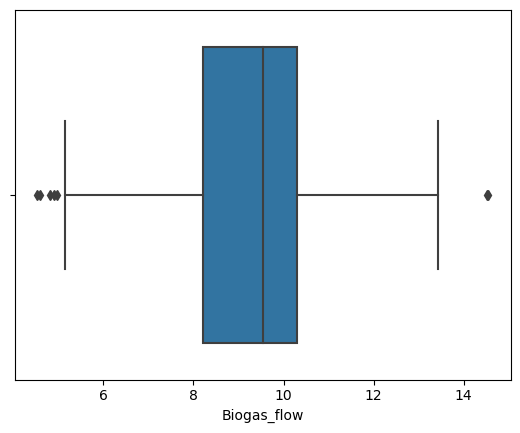

In [260]:
merged_Biogas1_3.describe()
sns.boxplot(x=merged_Biogas1_3['Biogas_flow'])

## 2.4: XGBoost Modelling

In [288]:
#Model Development

regressor2 = xgb.XGBRegressor()


regressor2.fit(X_train,y_train)
y_pred = regressor2.predict(X_test)
rmse_test= np.sqrt(mean_squared_error(y_test, y_pred))

print (rmse_test)

1.4235089873515703


In [291]:
###  XGBoost Configuration  ####
from sklearn.model_selection import RandomizedSearchCV

parameters = {'objective':['reg:squarederror'],'booster':['gbtree','gblinear','dart'],
'learning_rate': [0.01,0.02,0.05,0.1,0.2],'max_depth': [3,5,7,10],
'min_child_weight': [10,15,20,25],'colsample_bytree': [0.8, 0.9, 1],
'n_estimators': [100,200,300,400,500],"reg_alpha" : [0.5,0.2,1],
"reg_lambda" : [2,3,5],"gamma" : [3]}
grid_xgb2 = RandomizedSearchCV(regressor2,parameters, cv=5, n_iter=10, scoring='neg_mean_absolute_error', verbose=3, n_jobs=12)

grid_xgb2.fit(X_train, y_train, verbose = 1)

# Accessing detailed results
cv_results_df = pd.DataFrame(grid_xgb2.cv_results_)

# Extracting standard deviation of RMSE for each fold
std_rmse = cv_results_df[['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].std(axis=1)

# Extracting correlation coefficients (assuming you want Pearson correlation)
correlation_coef = cv_results_df[['param_learning_rate', 'param_max_depth', 'param_min_child_weight', 'param_colsample_bytree', 'param_n_estimators']].corr()

# Print the results
print("Standard Deviation of RMSE for each fold:")
print(std_rmse)

print("\nCorrelation Coefficients:")
print(correlation_coef)

y_pred = grid_xgb2.predict(X_test)
rmse_test= np.sqrt(mean_squared_error(y_test, y_pred))


print(grid_xgb2.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Standard Deviation of RMSE for each fold:
0    0.098484
1    0.160056
2    0.103079
3    0.166395
4    0.108317
5    0.170599
6    0.105393
7    0.119806
8    0.179228
9    0.092203
dtype: float64

Correlation Coefficients:
Empty DataFrame
Columns: []
Index: []
{'reg_lambda': 2, 'reg_alpha': 1, 'objective': 'reg:squarederror', 'n_estimators': 400, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 3, 'colsample_bytree': 0.9, 'booster': 'gbtree'}


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


In [321]:
regressor2 = xgb.XGBRegressor(max_depth=20, learning_rate=0.3, n_estimators=500, subsample=1, gamma=2, reg_alpha= 0.1)


regressor2.fit(X_train,y_train)
y_pred = regressor2.predict(X_test)
rmse_test= np.sqrt(mean_squared_error(y_test, y_pred))

print (rmse_test)

1.408657221306709


paramss={'reg_lambda': 3, 'reg_alpha': 0.001, 'objective': 'reg:squarederror', 'n_estimators': 200,
         'min_child_weight': 12, 'max_depth':3, 'learning_rate': 0.3, 'gamma': 3, 'colsample_bytree': 1,
         'booster': 'gbtree'}


In [322]:
# Define the cross-validation method
cv = KFold(n_splits=5, shuffle=True, random_state=42)
if isinstance(y2, np.ndarray):
    y2 = pd.Series(y2)
# Initialize lists to store scores
train_rmse_scores = []
test_rmse_scores = []
train_r2_scores = []
test_r2_scores = []

# Define your regressor
#regressor = XGBRegressor(random_state=42)

# Assuming X1 and y are properly defined as DataFrame and Series respectively
for train_index, test_index in cv.split(X2):
    X_train22, X_test22 = X2.iloc[train_index], X2.iloc[test_index]
    y_train22, y_test22 = y2.iloc[train_index], y2.iloc[test_index]
    

    
    # Predict on training and test data
    y_train_pred = regressor2.predict(X_train22)
    y_test_pred = regressor2.predict(X_test22)
    
    # Calculate RMSE for training and test data
    train_rmse = np.sqrt(mean_squared_error(y_train22, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test22, y_test_pred))
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    
    # Calculate R^2 for training and test data
    train_r2 = r2_score(y_train22, y_train_pred)
    test_r2 = r2_score(y_test22, y_test_pred)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Print training and testing RMSE and R^2 scores
print(f'Training RMSE scores: {train_rmse_scores}')
print(f'Testing RMSE scores: {test_rmse_scores}')
print(f'Mean Training RMSE: {np.mean(train_rmse_scores)}')
print(f'Mean Testing RMSE: {np.mean(test_rmse_scores)}')
print(f'Training R^2 scores: {train_r2_scores}')
print(f'Testing R^2 scores: {test_r2_scores}')
print(f'Mean Training R^2: {np.mean(train_r2_scores)}')
print(f'Mean Testing R^2: {np.mean(test_r2_scores)}')

Training RMSE scores: [0.5948722056096124, 0.8819165415441009, 0.9034169454533802, 0.9202597475979397, 0.895948121469372]
Testing RMSE scores: [1.4700843188509958, 0.6977214029621746, 0.576786830068501, 0.4575447445974729, 0.6218089475286099]
Mean Training RMSE: 0.839282712334881
Mean Testing RMSE: 0.7647892488015509
Training R^2 scores: [0.8601598313635497, 0.7280686612755056, 0.7234390285511445, 0.6854868118304922, 0.6916455240966513]
Testing R^2 scores: [0.38253532091287223, 0.7733473702460588, 0.8126471096247644, 0.9267939193603737, 0.8804679973728278]
Mean Training R^2: 0.7377599714234686
Mean Testing R^2: 0.7551583435033794


In [328]:
# Save data, model, and results
import pickle
with open('Scenario2_Biogas.pkl', 'wb') as f:
    pickle.dump({
        'X1': X1,
        'y': y,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'regressor': regressor2,
        'rmse_test': rmse_test,
        'rmse_train': rmse_train,
        'correlation_test': correlation_test,
        'correlation_train': correlation_train,
        'train_rmse_scores': train_rmse_scores,
        'test_rmse_scores': test_rmse_scores,
        'train_r2_scores': train_r2_scores,
        'test_r2_scores': test_r2_scores
    }, f)

print("Data and model configuration saved successfully.")


################### Load data, model, and results
#with open('Scenario1_Biogas.pkl', 'rb') as f:
    #data = pickle.load(f)


Data and model configuration saved successfully.


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


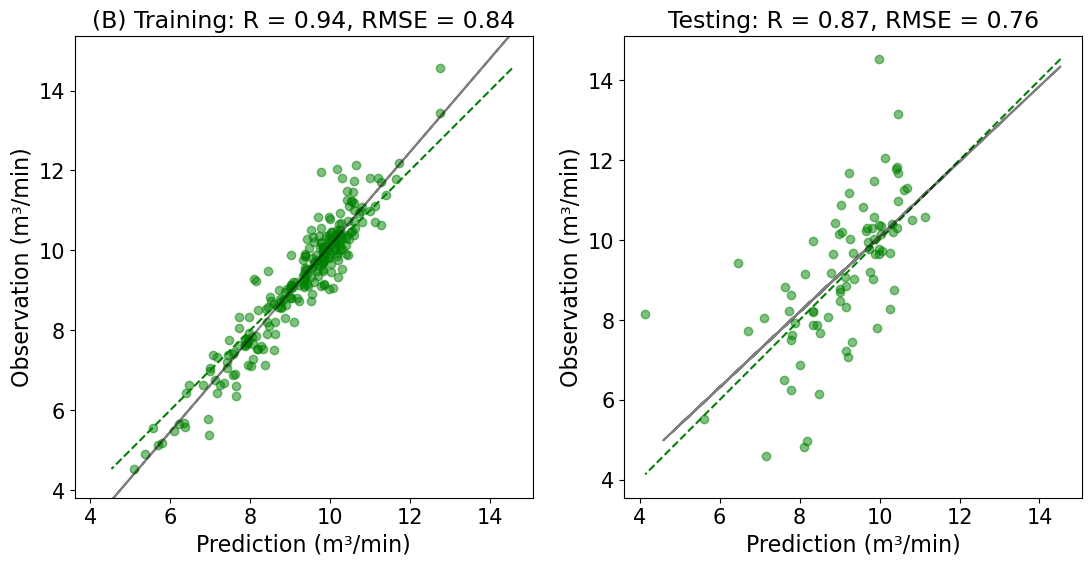

In [323]:
##PLot the results
# Predictions
y_test_pred = regressor2.predict(X_test)
y_train_pred = regressor2.predict(X_train)

# Calculate RMSE and R^2 values for training data
rmse_train = np.mean(train_rmse_scores)
r_train = np.sqrt(r2_score(y_train, y_train_pred))

# Calculate RMSE and R^2 values for testing data
rmse_test = np.mean(test_rmse_scores)
r_test = np.sqrt(np.mean(test_r2_scores))


##############   FIGURE  VISUALISATION  ##################
fig, (ax2,ax1)=plt.subplots(1,2,figsize=(13, 6),sharex=True)

ax2.scatter(y_train_pred, y_train, color='g' ,alpha = 0.5)

p1 = max(max(y_train_pred), max(y_train))
p2 = min(min(y_train_pred), min(y_train))
ax2.plot([p1,p2], [p1, p2], 'g--')


m2, b2 = np.polyfit(y_train_pred, y_train, 1)
ax2.plot(y_train, m2 * y_train + b2, color='k',linestyle='-', alpha = 0.5)

ax2.set_xlabel('Prediction (m\u00b3/min)', fontsize=16)
ax2.set_ylabel('Observation (m\u00b3/min)', fontsize=16)
ax2.axis('equal')
ax2.set_title(f'(B) Training: R = {r_train:.2f}, RMSE = {rmse_train:.2f}' ,fontsize=17)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)


ax1.scatter(y_test_pred, y_test, color='g' ,alpha = 0.5)
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'g--')

m1, b1 = np.polyfit(y_test_pred, y_test, 1)
ax1.plot(y_test, m1 * y_test + b1, color='k',linestyle='-', alpha = 0.5)

ax1.set_xlabel('Prediction (m\u00b3/min)', fontsize=16)
ax1.set_ylabel('Observation (m\u00b3/min)', fontsize=16)
ax1.axis('equal')
ax1.set_title(f'Testing: R = {r_test:.2f}, RMSE = {rmse_test:.2f}' ,fontsize=17)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)




fig.show()


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


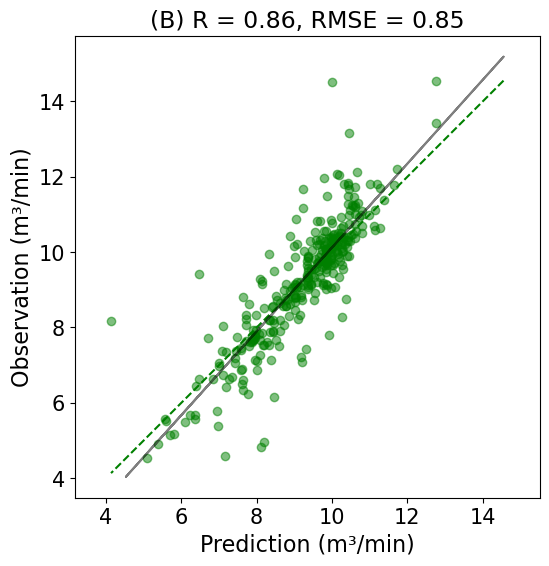

In [324]:
##PLot the results
y_pred_total2 = regressor2.predict(X2)

# Ensure y2 is float64
y2 = np.asarray(y2, dtype=np.float64)

# Ensure y_pred_total2 is float64
y_pred_total2 = np.asarray(y_pred_total2, dtype=np.float64)
# Calculate RMSE and R^2 values for training data
rmse_total2 = np.sqrt(mean_squared_error(y2, y_pred_total2))
r_total2 = np.sqrt(r2_score(y2, y_pred_total2))



##############   FIGURE  VISUALISATION  ##################
fig, (ax2)=plt.subplots(figsize=(6, 6),sharex=True)

ax2.scatter(y_pred_total2, y2, color='g',alpha = 0.5)

p1 = max(max(y_pred_total2), np.max(y2))
p2 = min(min(y_pred_total2), np.min(y2))
ax2.plot([p1,p2], [p1, p2], 'g--')


m2, b2 = np.polyfit(y_pred_total2, y2, 1)
ax2.plot(y2, m2 * y2 + b2, color='k',linestyle='-', alpha = 0.5)

ax2.set_xlabel('Prediction (m\u00b3/min)', fontsize=16)
ax2.set_ylabel('Observation (m\u00b3/min)', fontsize=16)
ax2.axis('equal')
ax2.set_title(f'(B) R = {r_total2:.2f}, RMSE = {rmse_total2:.2f}' ,fontsize=17)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

fig.show()



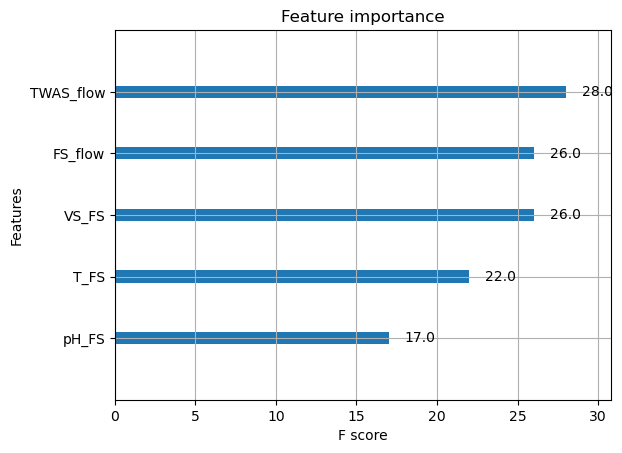

In [325]:
xgb.plot_importance(regressor2)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


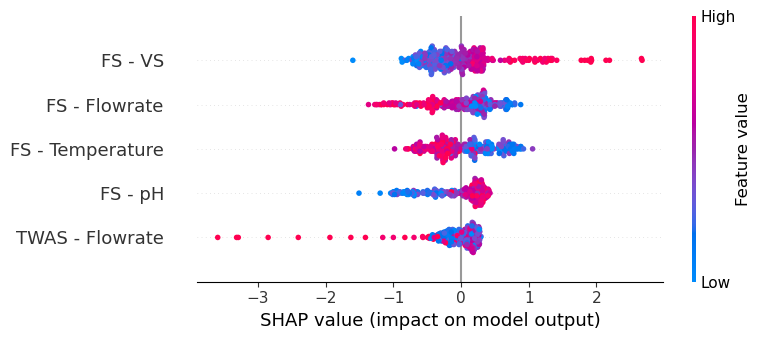

<Figure size 640x480 with 0 Axes>

In [326]:
# SHAP Analysis
custom_feature_names = [ "TWAS - Flowrate", "FS - pH","FS - VS","FS - Temperature", "FS - Flowrate"]  # Replace with your actual feature names


explainer = shap.TreeExplainer(regressor2)
shap_values = explainer.shap_values(X2)

# Summary plot
shap.summary_plot(shap_values, X2, feature_names=custom_feature_names)
plt.savefig('shap_summary_plot.png', dpi=1000, bbox_inches='tight')


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


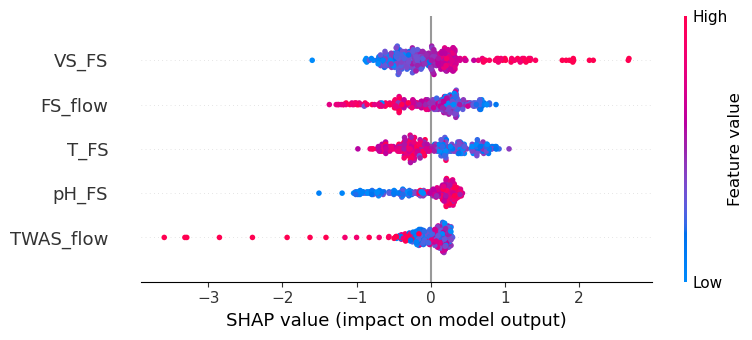

<Figure size 640x480 with 0 Axes>

In [367]:
# SHAP Analysis
#custom_feature_names = [ "TWAS - Flowrate", "FS - pH","FS - VS","FS - Temperature", "FS - Flowrate"]  # Replace with your actual feature names


explainer = shap.TreeExplainer(regressor2)
shap_values = explainer.shap_values(X2)

# Summary plot
shap.summary_plot(shap_values, X2)
plt.savefig('shap_summary_plot.png', dpi=1000, bbox_inches='tight')

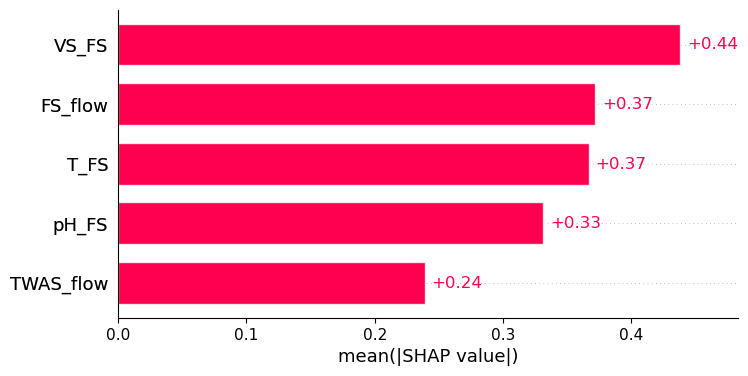

In [331]:
# Create the TreeExplainer and compute SHAP values
explainer = shap.Explainer(regressor2)
shap_values = explainer(X2)

# Now shap_values is an Explanation object, which can be directly used with plotting functions
shap.plots.bar(shap_values)

## 2.4: Bayesian Optimization

In [369]:
# Define the bounds for all the parameters to be optimized
pbounds = {'FS_flow': (1.0, 8.2),'TWAS_flow': (2.4, 11.03),
    'pH_FS': (4.75, 6.7),
    'VS_FS': (0.34, 6.9),'T_FS': (11.95, 21.7)}


# Define the optimization function with all parameters
def optimize_biogas(TWAS_flow, pH_FS, VS_FS, T_FS, FS_flow):
    # Create a DataFrame with the input values
    input_data = pd.DataFrame({'TWAS_flow': [TWAS_flow],
                               'pH_FS': [pH_FS], 'VS_FS': [VS_FS],
                               'T_FS': [T_FS],'FS_flow': [FS_flow]})

    # Use the trained XGBoost model to predict biogas production
    biogas_production = regressor2.predict(input_data)

    # Return the negative of biogas production since Bayesian Optimization aims to minimize
    return biogas_production[0]

# Initialize the optimizer with updated parameters
optimizer = BayesianOptimization(f=optimize_biogas, pbounds=pbounds, random_state=42)


# Perform the optimization
optimizer.maximize(init_points=5, n_iter=1500)

# Extract and print the results
results_df_combined2 = pd.DataFrame(optimizer.res, columns=['params', 'target'])
print(optimizer.max)


# Extract other parameters in the results DataFrame
def extract_params(params_dict):
    return [params_dict[param] for param in pbounds.keys()]

# Apply the extract_params function to the 'params' column
results_df_combined2[list(pbounds.keys())] = results_df_combined2['params'].apply(extract_params).apply(pd.Series)

# Drop the 'params' column
results_df_combined2.drop('params', axis=1, inplace=True)

results_df_combined2

|   iter    |  target   |  FS_flow  | TWAS_flow |   T_FS    |   VS_FS   |   pH_FS   |
-------------------------------------------------------------------------------------
| 1         | 3.871     | 3.697     | 10.6      | 19.09     | 4.267     | 5.054     |
| 2         | 9.811     | 2.123     | 2.901     | 20.4      | 4.283     | 6.131     |
| 3         | 4.33      | 1.148     | 10.77     | 20.07     | 1.733     | 5.105     |
| 4         | 8.086     | 2.321     | 5.026     | 17.07     | 3.174     | 5.318     |
| 5         | 8.484     | 5.405     | 3.604     | 14.8      | 2.743     | 5.639     |
| 6         | 7.584     | 8.2       | 2.4       | 21.7      | 0.34      | 6.7       |
| 7         | 9.611     | 1.0       | 2.4       | 15.38     | 6.9       | 6.7       |
| 8         | 10.03     | 1.0       | 2.4       | 11.95     | 0.34      | 6.7       |
| 9         | 7.783     | 1.0       | 2.4       | 21.7      | 0.34      | 4.75      |
| 10        | 9.442     | 6.317     | 2.4       | 21.7

| 58        | 11.49     | 4.981     | 6.252     | 17.42     | 6.9       | 4.75      |
| 59        | 11.33     | 6.076     | 5.187     | 16.44     | 6.9       | 4.75      |
| 60        | 11.94     | 3.915     | 3.793     | 20.11     | 6.418     | 5.995     |
| 61        | 11.94     | 4.214     | 3.224     | 20.12     | 6.417     | 6.7       |
| 62        | 12.31     | 3.892     | 5.118     | 20.11     | 6.9       | 6.394     |
| 63        | 12.31     | 4.007     | 6.565     | 19.8      | 6.9       | 6.7       |
| 64        | 12.43     | 4.566     | 6.589     | 21.06     | 6.9       | 6.7       |
| 65        | 8.099     | 4.292     | 8.267     | 21.7      | 6.9       | 6.7       |
| 66        | 11.38     | 4.954     | 5.563     | 21.5      | 6.9       | 6.7       |
| 67        | 12.6      | 4.517     | 6.211     | 20.5      | 6.043     | 6.7       |
| 68        | 11.09     | 4.883     | 6.508     | 20.24     | 6.9       | 6.078     |
| 69        | 12.43     | 3.739     | 6.166     | 20.8

| 116       | 9.092     | 1.0       | 6.452     | 16.05     | 0.34      | 6.7       |
| 117       | 6.894     | 1.0       | 6.566     | 11.95     | 4.115     | 4.75      |
| 118       | 9.476     | 4.057     | 2.4       | 18.6      | 0.34      | 6.7       |
| 119       | 7.923     | 5.925     | 2.4       | 21.7      | 3.95      | 4.75      |
| 120       | 10.14     | 2.35      | 3.953     | 13.78     | 4.284     | 6.7       |
| 121       | 10.4      | 8.2       | 4.346     | 14.52     | 6.9       | 6.7       |
| 122       | 10.68     | 6.77      | 7.048     | 15.36     | 6.9       | 4.75      |
| 123       | 11.23     | 3.532     | 5.942     | 20.46     | 5.476     | 6.7       |
| 124       | 9.493     | 5.184     | 5.117     | 11.95     | 5.422     | 6.7       |
| 125       | 7.365     | 5.393     | 11.03     | 14.63     | 6.9       | 4.75      |
| 126       | 9.847     | 2.715     | 4.734     | 13.51     | 0.34      | 6.7       |
| 127       | 9.739     | 1.0       | 2.4       | 17.5

| 174       | 11.56     | 4.358     | 5.98      | 18.44     | 6.156     | 5.63      |
| 175       | 10.99     | 4.504     | 4.57      | 19.1      | 5.72      | 6.7       |
| 176       | 5.674     | 8.2       | 11.03     | 16.28     | 0.34      | 6.7       |
| 177       | 12.43     | 4.099     | 6.215     | 21.7      | 6.9       | 6.7       |
| 178       | 10.05     | 4.486     | 5.011     | 16.34     | 5.667     | 4.75      |
| 179       | 10.84     | 2.942     | 6.141     | 16.34     | 5.863     | 6.467     |
| 180       | 8.737     | 4.722     | 5.698     | 21.7      | 0.34      | 6.7       |
| 181       | 11.0      | 4.238     | 2.4       | 14.77     | 6.9       | 6.7       |
| 182       | 7.287     | 1.0       | 2.4       | 21.7      | 4.095     | 4.75      |
| 183       | 11.56     | 3.818     | 6.172     | 17.42     | 6.9       | 5.764     |
| 184       | 9.624     | 8.2       | 2.4       | 14.54     | 0.34      | 6.7       |
| 185       | 9.637     | 1.0       | 3.972     | 21.7

| 232       | 10.69     | 4.33      | 6.169     | 20.31     | 5.712     | 5.445     |
| 233       | 12.43     | 3.977     | 5.308     | 21.41     | 6.667     | 6.183     |
| 234       | 6.803     | 5.223     | 11.03     | 11.95     | 3.443     | 6.7       |
| 235       | 10.68     | 5.644     | 3.138     | 15.59     | 5.998     | 6.7       |
| 236       | 12.43     | 4.209     | 6.205     | 21.07     | 6.402     | 6.303     |
| 237       | 11.95     | 3.55      | 4.199     | 20.75     | 6.852     | 5.952     |
| 238       | 12.31     | 4.631     | 6.176     | 19.09     | 6.9       | 6.7       |
| 239       | 8.671     | 5.36      | 2.4       | 21.7      | 0.34      | 4.75      |
| 240       | 12.43     | 3.593     | 6.009     | 21.62     | 6.07      | 6.339     |
| 241       | 10.84     | 3.247     | 4.072     | 16.34     | 5.6       | 6.7       |
| 242       | 11.6      | 4.438     | 5.452     | 18.6      | 6.9       | 6.293     |
| 243       | 11.32     | 3.752     | 6.525     | 21.7

| 290       | 11.56     | 4.679     | 5.427     | 17.21     | 6.473     | 5.785     |
| 291       | 11.06     | 4.97      | 3.653     | 13.47     | 6.06      | 4.75      |
| 292       | 7.762     | 4.304     | 3.726     | 11.95     | 4.328     | 4.75      |
| 293       | 9.271     | 2.256     | 6.648     | 18.67     | 6.9       | 4.75      |
| 294       | 12.31     | 4.696     | 6.049     | 20.04     | 6.78      | 6.499     |
| 295       | 10.6      | 6.166     | 4.038     | 12.81     | 6.9       | 4.75      |
| 296       | 12.6      | 4.237     | 6.299     | 20.62     | 5.998     | 6.398     |
| 297       | 10.9      | 4.973     | 3.115     | 14.15     | 6.9       | 5.468     |
| 298       | 12.31     | 4.443     | 5.359     | 19.86     | 6.625     | 5.831     |
| 299       | 11.94     | 3.022     | 2.4       | 20.16     | 6.9       | 5.907     |
| 300       | 10.43     | 1.0       | 4.279     | 11.95     | 4.513     | 6.7       |
| 301       | 11.37     | 2.89      | 6.311     | 15.4

| 348       | 11.94     | 3.732     | 3.667     | 19.45     | 6.9       | 5.455     |
| 349       | 11.27     | 5.855     | 4.11      | 20.62     | 6.071     | 4.75      |
| 350       | 12.22     | 5.348     | 4.632     | 21.21     | 6.471     | 4.75      |
| 351       | 12.31     | 3.963     | 5.558     | 20.68     | 6.216     | 5.953     |
| 352       | 9.624     | 8.2       | 2.4       | 13.29     | 2.531     | 6.7       |
| 353       | 11.43     | 4.352     | 5.818     | 18.51     | 6.205     | 6.7       |
| 354       | 10.23     | 1.0       | 4.498     | 14.59     | 5.019     | 6.7       |
| 355       | 12.31     | 3.316     | 5.482     | 20.73     | 6.9       | 6.141     |
| 356       | 12.1      | 5.058     | 4.58      | 20.29     | 6.303     | 5.073     |
| 357       | 12.43     | 4.326     | 5.082     | 21.64     | 6.34      | 5.985     |
| 358       | 12.43     | 3.002     | 4.355     | 20.83     | 6.114     | 6.534     |
| 359       | 12.31     | 4.504     | 5.985     | 20.1

| 406       | 7.68      | 3.75      | 7.031     | 11.95     | 2.346     | 6.7       |
| 407       | 7.774     | 3.051     | 5.104     | 21.7      | 0.34      | 4.75      |
| 408       | 12.43     | 3.352     | 4.969     | 21.7      | 6.132     | 6.596     |
| 409       | 11.32     | 3.145     | 5.569     | 21.55     | 5.842     | 6.276     |
| 410       | 4.135     | 8.2       | 11.03     | 18.68     | 3.317     | 4.75      |
| 411       | 10.28     | 3.833     | 4.824     | 17.37     | 4.916     | 6.7       |
| 412       | 12.31     | 3.289     | 6.037     | 19.34     | 6.532     | 6.7       |
| 413       | 9.595     | 3.991     | 2.4       | 14.98     | 5.455     | 4.75      |
| 414       | 6.139     | 8.2       | 6.357     | 21.7      | 0.34      | 6.7       |
| 415       | 9.617     | 2.29      | 4.889     | 16.03     | 6.861     | 6.623     |
| 416       | 10.28     | 1.0       | 2.4       | 13.54     | 4.991     | 6.7       |
| 417       | 12.43     | 2.781     | 4.877     | 21.2

| 464       | 12.43     | 3.303     | 6.099     | 21.66     | 6.783     | 6.052     |
| 465       | 12.31     | 2.965     | 6.12      | 19.54     | 6.627     | 5.845     |
| 466       | 12.43     | 3.329     | 5.64      | 21.55     | 6.78      | 5.435     |
| 467       | 9.256     | 8.2       | 4.368     | 11.95     | 2.356     | 6.7       |
| 468       | 9.639     | 5.929     | 6.416     | 11.95     | 6.9       | 6.7       |
| 469       | 12.31     | 4.387     | 4.689     | 20.28     | 6.511     | 5.472     |
| 470       | 9.194     | 1.0       | 7.008     | 21.7      | 6.9       | 6.7       |
| 471       | 11.44     | 5.44      | 5.857     | 15.52     | 6.022     | 6.7       |
| 472       | 11.0      | 4.506     | 2.4       | 13.25     | 6.166     | 6.7       |
| 473       | 9.476     | 2.273     | 6.031     | 18.75     | 5.634     | 6.7       |
| 474       | 11.08     | 3.235     | 5.683     | 19.53     | 5.704     | 5.823     |
| 475       | 11.43     | 3.783     | 4.693     | 17.1

| 522       | 11.13     | 3.889     | 3.16      | 15.67     | 6.59      | 5.698     |
| 523       | 10.78     | 5.27      | 2.4       | 15.64     | 6.9       | 5.995     |
| 524       | 12.43     | 4.393     | 6.054     | 21.35     | 6.222     | 5.924     |
| 525       | 11.37     | 3.403     | 5.767     | 15.37     | 6.361     | 6.7       |
| 526       | 12.31     | 2.936     | 5.911     | 19.45     | 6.652     | 6.163     |
| 527       | 12.43     | 4.086     | 5.714     | 21.32     | 6.295     | 5.713     |
| 528       | 11.95     | 4.771     | 5.06      | 20.13     | 6.331     | 5.611     |
| 529       | 11.94     | 4.637     | 3.156     | 20.77     | 6.849     | 6.311     |
| 530       | 12.31     | 4.009     | 5.268     | 19.8      | 6.438     | 6.125     |
| 531       | 12.31     | 3.912     | 6.159     | 20.67     | 6.093     | 6.665     |
| 532       | 12.43     | 3.076     | 6.431     | 21.15     | 6.9       | 6.7       |
| 533       | 9.476     | 2.709     | 2.4       | 20.1

| 580       | 12.43     | 4.209     | 5.511     | 21.7      | 6.9       | 6.7       |
| 581       | 11.75     | 5.774     | 4.872     | 21.7      | 6.634     | 4.75      |
| 582       | 9.805     | 4.836     | 2.4       | 13.27     | 2.877     | 6.7       |
| 583       | 12.31     | 3.672     | 4.296     | 20.07     | 6.501     | 6.375     |
| 584       | 9.598     | 7.355     | 2.4       | 21.7      | 6.9       | 4.75      |
| 585       | 11.06     | 4.964     | 2.4       | 13.33     | 6.292     | 4.75      |
| 586       | 11.49     | 3.367     | 6.374     | 20.92     | 6.553     | 5.267     |
| 587       | 9.635     | 3.26      | 7.155     | 20.1      | 6.873     | 5.748     |
| 588       | 12.31     | 3.114     | 6.121     | 20.04     | 6.531     | 5.911     |
| 589       | 9.654     | 3.885     | 3.404     | 12.89     | 5.395     | 6.7       |
| 590       | 12.12     | 3.492     | 4.063     | 19.02     | 5.919     | 6.492     |
| 591       | 12.43     | 4.106     | 6.04      | 21.6

| 638       | 12.1      | 5.318     | 5.625     | 19.56     | 6.9       | 4.75      |
| 639       | 10.33     | 4.923     | 5.953     | 19.19     | 5.747     | 5.635     |
| 640       | 12.43     | 3.684     | 5.231     | 21.2      | 6.9       | 5.618     |
| 641       | 12.43     | 3.716     | 6.017     | 21.33     | 6.32      | 5.908     |
| 642       | 11.37     | 4.554     | 6.448     | 20.66     | 6.9       | 4.75      |
| 643       | 7.705     | 1.0       | 2.4       | 11.95     | 1.634     | 4.75      |
| 644       | 8.127     | 8.2       | 2.4       | 14.79     | 2.63      | 4.75      |
| 645       | 9.811     | 2.861     | 2.4       | 19.3      | 4.282     | 6.7       |
| 646       | 9.993     | 1.0       | 4.891     | 11.95     | 0.34      | 6.7       |
| 647       | 9.585     | 8.2       | 2.4       | 16.63     | 6.9       | 4.75      |
| 648       | 12.31     | 3.017     | 6.468     | 19.83     | 6.095     | 6.258     |
| 649       | 12.43     | 4.665     | 4.434     | 21.1

| 696       | 12.31     | 3.153     | 4.825     | 20.15     | 6.285     | 5.584     |
| 697       | 11.37     | 5.453     | 6.436     | 21.7      | 6.9       | 4.75      |
| 698       | 12.43     | 4.509     | 5.614     | 21.7      | 6.422     | 5.78      |
| 699       | 10.92     | 4.335     | 5.077     | 17.87     | 5.762     | 5.671     |
| 700       | 9.378     | 2.882     | 3.84      | 15.72     | 2.59      | 6.7       |
| 701       | 9.489     | 8.2       | 7.312     | 16.04     | 6.9       | 4.75      |
| 702       | 12.43     | 4.195     | 4.722     | 21.38     | 6.508     | 6.677     |
| 703       | 7.032     | 1.0       | 11.03     | 19.22     | 6.9       | 6.7       |
| 704       | 12.31     | 3.599     | 4.557     | 20.4      | 6.825     | 6.655     |
| 705       | 10.05     | 4.057     | 4.871     | 14.08     | 5.415     | 4.75      |
| 706       | 10.03     | 4.16      | 2.4       | 13.38     | 1.088     | 6.7       |
| 707       | 12.43     | 3.683     | 6.481     | 21.1

| 754       | 12.31     | 3.074     | 6.328     | 20.75     | 6.217     | 6.607     |
| 755       | 12.43     | 4.336     | 4.655     | 20.79     | 6.109     | 5.689     |
| 756       | 12.43     | 3.003     | 6.065     | 21.06     | 6.672     | 5.866     |
| 757       | 12.07     | 3.699     | 3.81      | 21.63     | 6.102     | 5.785     |
| 758       | 12.43     | 3.022     | 6.087     | 21.34     | 6.859     | 5.782     |
| 759       | 12.22     | 5.04      | 5.886     | 21.7      | 6.381     | 4.75      |
| 760       | 12.31     | 3.763     | 4.858     | 19.06     | 6.216     | 5.614     |
| 761       | 9.778     | 6.111     | 2.4       | 11.95     | 5.322     | 4.75      |
| 762       | 8.977     | 4.175     | 7.566     | 14.98     | 6.9       | 4.75      |
| 763       | 12.43     | 4.233     | 6.331     | 21.24     | 6.9       | 6.7       |
| 764       | 11.32     | 3.92      | 5.713     | 21.7      | 5.768     | 6.7       |
| 765       | 12.31     | 3.767     | 4.942     | 20.4

| 812       | 10.59     | 3.544     | 3.941     | 18.41     | 5.66      | 5.908     |
| 813       | 12.43     | 4.243     | 4.497     | 21.59     | 6.235     | 6.05      |
| 814       | 10.96     | 3.84      | 2.4       | 19.35     | 5.459     | 6.7       |
| 815       | 11.94     | 3.741     | 3.865     | 19.63     | 6.263     | 6.644     |
| 816       | 11.59     | 4.843     | 4.227     | 20.25     | 6.708     | 5.508     |
| 817       | 11.12     | 5.969     | 4.29      | 19.61     | 6.352     | 5.936     |
| 818       | 11.94     | 4.327     | 2.943     | 19.84     | 6.9       | 6.185     |
| 819       | 8.053     | 5.393     | 2.4       | 16.93     | 2.929     | 4.75      |
| 820       | 11.95     | 3.202     | 4.259     | 19.83     | 6.648     | 5.509     |
| 821       | 6.784     | 5.584     | 7.22      | 21.7      | 0.34      | 4.75      |
| 822       | 12.58     | 4.526     | 4.45      | 21.69     | 6.118     | 5.345     |
| 823       | 11.49     | 4.454     | 4.487     | 21.3

| 870       | 9.925     | 4.72      | 4.542     | 13.25     | 3.551     | 6.7       |
| 871       | 11.71     | 5.287     | 2.722     | 21.55     | 6.855     | 5.491     |
| 872       | 12.31     | 2.95      | 5.654     | 20.64     | 6.382     | 6.7       |
| 873       | 8.851     | 1.0       | 5.878     | 13.81     | 0.34      | 6.7       |
| 874       | 10.96     | 6.043     | 2.4       | 15.1      | 6.9       | 4.75      |
| 875       | 9.913     | 8.18      | 6.269     | 13.51     | 4.68      | 6.695     |
| 876       | 11.07     | 3.047     | 3.466     | 18.35     | 6.9       | 6.7       |
| 877       | 12.07     | 3.53      | 3.359     | 21.7      | 6.9       | 5.567     |
| 878       | 11.37     | 3.873     | 5.038     | 14.59     | 6.415     | 6.7       |
| 879       | 10.91     | 5.4       | 5.47      | 14.5      | 5.754     | 5.587     |
| 880       | 10.97     | 5.267     | 3.255     | 16.98     | 6.9       | 5.719     |
| 881       | 4.878     | 8.2       | 8.65      | 21.7

| 928       | 9.437     | 6.013     | 4.242     | 11.95     | 1.579     | 6.7       |
| 929       | 10.12     | 6.573     | 6.093     | 11.95     | 4.544     | 6.7       |
| 930       | 11.0      | 4.048     | 2.4       | 13.33     | 6.9       | 6.7       |
| 931       | 7.817     | 5.033     | 2.4       | 13.6      | 4.064     | 4.75      |
| 932       | 11.43     | 3.686     | 6.329     | 17.58     | 6.385     | 6.7       |
| 933       | 8.871     | 2.245     | 6.117     | 16.74     | 6.9       | 4.75      |
| 934       | 11.02     | 3.646     | 4.346     | 18.6      | 6.53      | 5.246     |
| 935       | 10.51     | 5.807     | 2.526     | 17.88     | 6.698     | 4.797     |
| 936       | 12.31     | 3.147     | 6.068     | 19.72     | 6.194     | 5.95      |
| 937       | 10.03     | 4.36      | 2.4       | 11.95     | 2.093     | 6.7       |
| 938       | 8.805     | 1.0       | 6.041     | 11.95     | 6.9       | 4.75      |
| 939       | 11.23     | 3.965     | 5.6       | 19.1

| 986       | 12.31     | 3.841     | 5.674     | 19.49     | 6.325     | 6.7       |
| 987       | 9.823     | 4.764     | 3.553     | 16.4      | 6.066     | 5.551     |
| 988       | 10.55     | 2.386     | 3.266     | 19.53     | 6.9       | 6.7       |
| 989       | 12.6      | 3.545     | 6.732     | 20.52     | 6.023     | 6.7       |
| 990       | 11.13     | 2.867     | 3.63      | 15.21     | 6.165     | 5.682     |
| 991       | 10.88     | 4.912     | 2.4       | 18.53     | 6.9       | 5.897     |
| 992       | 12.43     | 3.281     | 4.924     | 20.82     | 6.174     | 5.711     |
| 993       | 11.01     | 3.893     | 2.421     | 20.54     | 6.88      | 4.929     |
| 994       | 11.24     | 4.043     | 3.217     | 18.54     | 6.287     | 6.7       |
| 995       | 11.0      | 3.863     | 3.405     | 14.11     | 6.333     | 5.881     |
| 996       | 7.644     | 8.2       | 2.4       | 17.89     | 5.744     | 6.7       |
| 997       | 11.95     | 3.741     | 4.134     | 20.5

| 1044      | 12.43     | 4.083     | 6.694     | 21.7      | 6.527     | 6.7       |
| 1045      | 9.763     | 5.742     | 5.106     | 13.09     | 6.9       | 5.623     |
| 1046      | 9.323     | 1.0       | 6.295     | 11.95     | 2.259     | 6.7       |
| 1047      | 11.24     | 5.209     | 3.695     | 19.0      | 6.9       | 5.433     |
| 1048      | 10.62     | 4.356     | 5.656     | 17.83     | 6.385     | 4.961     |
| 1049      | 9.858     | 1.965     | 2.4       | 15.09     | 2.015     | 6.7       |
| 1050      | 10.29     | 3.517     | 2.4       | 11.95     | 3.721     | 6.7       |
| 1051      | 10.98     | 3.759     | 6.85      | 20.19     | 6.9       | 4.75      |
| 1052      | 9.174     | 1.0       | 4.642     | 19.73     | 2.336     | 6.7       |
| 1053      | 9.321     | 8.2       | 6.985     | 19.19     | 6.9       | 4.75      |
| 1054      | 11.42     | 5.526     | 4.784     | 14.11     | 6.405     | 4.752     |
| 1055      | 9.489     | 8.2       | 7.601     | 13.3

| 1102      | 9.646     | 1.0       | 3.752     | 21.7      | 4.182     | 6.7       |
| 1103      | 7.047     | 8.2       | 4.507     | 21.7      | 0.34      | 4.75      |
| 1104      | 12.31     | 3.762     | 5.428     | 19.05     | 6.9       | 6.7       |
| 1105      | 10.68     | 6.967     | 5.01      | 13.83     | 6.9       | 4.75      |
| 1106      | 9.74      | 1.0       | 4.007     | 21.7      | 6.9       | 4.75      |
| 1107      | 12.1      | 5.409     | 4.88      | 20.37     | 6.45      | 5.191     |
| 1108      | 11.33     | 5.713     | 5.658     | 15.53     | 6.9       | 5.093     |
| 1109      | 11.94     | 3.423     | 2.937     | 19.71     | 6.9       | 5.558     |
| 1110      | 12.43     | 2.976     | 5.204     | 20.94     | 6.581     | 6.423     |
| 1111      | 12.07     | 3.201     | 2.919     | 20.88     | 6.713     | 6.099     |
| 1112      | 11.49     | 5.04      | 6.612     | 17.46     | 6.118     | 5.171     |
| 1113      | 11.94     | 3.415     | 3.42      | 20.1

| 1160      | 11.37     | 4.025     | 4.81      | 16.59     | 6.9       | 6.032     |
| 1161      | 11.43     | 3.935     | 5.708     | 17.26     | 6.156     | 6.056     |
| 1162      | 11.94     | 3.133     | 2.4       | 20.35     | 6.269     | 5.475     |
| 1163      | 10.92     | 3.301     | 6.021     | 16.69     | 5.958     | 5.262     |
| 1164      | 12.43     | 3.0       | 6.12      | 20.99     | 6.9       | 5.45      |
| 1165      | 12.31     | 3.199     | 5.398     | 19.01     | 6.254     | 5.721     |
| 1166      | 12.43     | 3.386     | 6.461     | 21.66     | 6.455     | 5.647     |
| 1167      | 11.96     | 3.405     | 5.64      | 18.94     | 6.558     | 6.196     |
| 1168      | 12.43     | 4.696     | 6.09      | 21.17     | 6.8       | 5.438     |
| 1169      | 12.07     | 4.181     | 2.967     | 21.16     | 6.9       | 6.7       |
| 1170      | 11.02     | 4.716     | 4.801     | 18.86     | 6.084     | 5.057     |
| 1171      | 9.782     | 6.21      | 4.757     | 18.4

| 1218      | 12.43     | 4.19      | 6.756     | 21.7      | 6.9       | 6.7       |
| 1219      | 12.43     | 3.726     | 5.383     | 21.29     | 6.37      | 5.657     |
| 1220      | 12.07     | 3.54      | 4.164     | 21.42     | 6.687     | 6.7       |
| 1221      | 10.91     | 5.185     | 5.783     | 18.89     | 6.169     | 6.7       |
| 1222      | 11.01     | 2.715     | 2.4       | 19.29     | 6.129     | 5.204     |
| 1223      | 12.43     | 4.571     | 5.4       | 21.02     | 6.238     | 5.811     |
| 1224      | 11.02     | 3.824     | 6.215     | 18.7      | 6.9       | 4.75      |
| 1225      | 12.43     | 3.132     | 4.864     | 21.61     | 6.25      | 5.968     |
| 1226      | 11.49     | 3.223     | 4.577     | 14.71     | 6.238     | 5.754     |
| 1227      | 9.263     | 1.0       | 2.4       | 16.64     | 5.474     | 6.7       |
| 1228      | 12.31     | 4.291     | 4.45      | 19.28     | 6.9       | 5.776     |
| 1229      | 12.43     | 2.978     | 4.896     | 21.3

| 1276      | 12.31     | 2.991     | 5.317     | 19.14     | 6.9       | 5.596     |
| 1277      | 11.33     | 5.921     | 5.255     | 14.7      | 6.627     | 4.75      |
| 1278      | 11.96     | 4.268     | 5.369     | 18.91     | 6.175     | 5.537     |
| 1279      | 12.1      | 5.246     | 5.166     | 19.78     | 6.605     | 5.034     |
| 1280      | 12.43     | 4.48      | 5.691     | 21.6      | 6.288     | 6.246     |
| 1281      | 12.43     | 3.648     | 5.388     | 21.65     | 6.667     | 5.446     |
| 1282      | 11.94     | 3.248     | 2.4       | 19.39     | 6.9       | 6.304     |
| 1283      | 12.46     | 3.926     | 4.397     | 19.89     | 6.9       | 5.389     |
| 1284      | 10.16     | 8.2       | 4.271     | 15.17     | 6.9       | 5.653     |
| 1285      | 10.28     | 5.196     | 5.847     | 21.7      | 5.809     | 6.7       |
| 1286      | 9.489     | 6.804     | 7.229     | 11.95     | 6.9       | 4.75      |
| 1287      | 12.31     | 4.166     | 5.249     | 19.1

| 1334      | 12.43     | 3.371     | 5.225     | 21.2      | 6.819     | 5.792     |
| 1335      | 11.06     | 4.615     | 4.921     | 17.01     | 5.543     | 6.7       |
| 1336      | 12.6      | 2.768     | 4.607     | 19.42     | 6.014     | 5.64      |
| 1337      | 11.39     | 5.573     | 4.247     | 21.56     | 6.342     | 4.754     |
| 1338      | 10.29     | 3.247     | 2.4       | 18.52     | 5.274     | 5.718     |
| 1339      | 12.31     | 4.473     | 6.185     | 19.68     | 6.539     | 6.406     |
| 1340      | 11.06     | 5.486     | 2.4       | 16.01     | 6.9       | 4.75      |
| 1341      | 6.765     | 5.519     | 8.234     | 14.67     | 3.161     | 6.7       |
| 1342      | 12.43     | 2.985     | 6.406     | 21.41     | 6.893     | 6.13      |
| 1343      | 10.16     | 6.925     | 2.4       | 14.37     | 6.9       | 5.596     |
| 1344      | 11.31     | 3.805     | 4.056     | 14.99     | 6.296     | 5.68      |
| 1345      | 12.43     | 3.619     | 5.445     | 21.0

| 1392      | 10.78     | 4.385     | 4.333     | 13.64     | 5.886     | 5.769     |
| 1393      | 10.97     | 7.671     | 5.837     | 14.43     | 6.043     | 4.75      |
| 1394      | 11.94     | 4.743     | 3.097     | 19.97     | 6.9       | 6.7       |
| 1395      | 11.37     | 4.419     | 4.503     | 15.15     | 6.9       | 6.7       |
| 1396      | 11.13     | 3.771     | 2.4       | 16.28     | 6.9       | 5.767     |
| 1397      | 10.09     | 1.987     | 5.343     | 14.39     | 3.983     | 6.7       |
| 1398      | 10.01     | 4.741     | 6.86      | 15.52     | 6.9       | 5.739     |
| 1399      | 11.94     | 3.58      | 3.043     | 20.59     | 6.396     | 6.087     |
| 1400      | 9.955     | 8.2       | 5.323     | 21.7      | 6.9       | 4.75      |
| 1401      | 10.68     | 2.402     | 4.392     | 21.7      | 6.004     | 6.7       |
| 1402      | 11.87     | 5.227     | 2.832     | 21.64     | 6.685     | 4.801     |
| 1403      | 12.6      | 3.115     | 5.045     | 19.1

| 1450      | 10.56     | 2.473     | 5.551     | 20.51     | 6.854     | 6.681     |
| 1451      | 9.729     | 2.14      | 2.4       | 16.36     | 3.153     | 6.7       |
| 1452      | 12.31     | 4.587     | 5.837     | 20.73     | 6.866     | 5.698     |
| 1453      | 11.07     | 2.931     | 2.436     | 18.23     | 6.659     | 6.147     |
| 1454      | 11.39     | 5.343     | 3.539     | 18.87     | 6.099     | 4.75      |
| 1455      | 9.624     | 6.491     | 2.4       | 15.06     | 0.34      | 6.7       |
| 1456      | 11.95     | 4.978     | 4.902     | 19.36     | 6.9       | 5.937     |
| 1457      | 11.03     | 3.479     | 3.384     | 21.7      | 5.835     | 6.537     |
| 1458      | 10.75     | 5.279     | 5.821     | 17.51     | 5.822     | 5.752     |
| 1459      | 12.31     | 3.135     | 5.775     | 19.11     | 6.9       | 6.7       |
| 1460      | 11.43     | 3.261     | 6.499     | 17.09     | 6.9       | 6.001     |
| 1461      | 11.94     | 3.45      | 3.001     | 19.9

,target,FS_flow,TWAS_flow,pH_FS,VS_FS,T_FS
0,3.871044,3.696689,10.604664,5.054236,4.267200,19.086941
1,9.811366,2.123161,2.901262,6.130742,4.283314,20.395217
2,4.330087,1.148208,10.770322,5.104559,1.732945,20.066316
3,8.085696,2.320512,5.025611,5.317897,3.173559,17.066375
4,8.483917,5.405341,3.603832,5.639336,2.743334,14.798410
...,...,...,...,...,...,...
1500,11.034749,4.955327,6.603809,4.750000,5.792384,17.136537
1501,9.846785,4.489256,5.115808,6.700000,1.207923,13.014890
1502,10.192696,4.399080,2.400000,5.232713,6.130908,14.064290
1503,12.305120,3.308020,5.362545,5.429459,6.815947,19.139994


In [382]:
# Save the optimizer, model, and results DataFrame
with open('optimizer_model_results_Biogas_MixingRatio_Scenario2.pkl', 'wb') as f:
    pickle.dump((optimizer, regressor2, results_df_combined2), f)

In [370]:
results_df_combined2.describe()

,target,FS_flow,TWAS_flow,pH_FS,VS_FS,T_FS
count,1505.000000,1505.000000,1505.000000,1505.000000,1505.000000,1505.000000
mean,10.678485,4.250081,4.937478,5.931781,5.606255,18.039101
std,1.736035,1.794449,1.847687,0.768028,1.879835,3.130250
min,3.689997,1.000000,2.400000,4.750000,0.340000,11.950000
25%,9.756121,3.167916,3.613132,5.294379,5.536756,15.360218
50%,11.060159,4.062943,4.971434,6.039429,6.311849,19.103053
75%,12.102572,5.226831,6.036060,6.700000,6.900000,20.742220
max,12.602297,8.200000,11.030000,6.700000,6.900000,21.700000


In [374]:
## A dataframe with Biogas > 10
limit = 9.74 # average biogas production rate from the plant
new_results_df_combined2 = results_df_combined2[results_df_combined2['target'] > limit]
new_results_df_combined2.reset_index(drop=True,inplace = True)


# add new columns to new dataframe
new_results_df_combined2 = new_results_df_combined2.assign(FS_percent =new_results_df_combined2['FS_flow']/(new_results_df_combined2['TWAS_flow']+
                                       new_results_df_combined2['FS_flow']),
                                       TWAS_percent =new_results_df_combined2['TWAS_flow']/(new_results_df_combined2['TWAS_flow']+
                                       new_results_df_combined2['FS_flow']))

new_results_df_combined2 = new_results_df_combined2.assign(FS_TWAS =new_results_df_combined2['FS_flow']/
                                                           new_results_df_combined2['TWAS_flow'])

new_results_df_combined2 ###Mixing ratios
new_results_df_combined2.describe()


,target,FS_flow,TWAS_flow,pH_FS,VS_FS,T_FS,FS_percent,TWAS_percent,FS_TWAS
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,11.459584,4.201396,4.753373,5.948562,6.251425,18.479517,0.468385,0.531615,0.981509
std,0.854346,1.377149,1.369079,0.697940,0.968261,2.928482,0.111554,0.111554,0.506704
min,9.740431,1.000000,2.400000,4.750000,0.340000,11.950000,0.128476,0.226415,0.147415
25%,10.757122,3.299308,3.812670,5.476592,6.071498,16.209545,0.392177,0.459838,0.645215
50%,11.556278,4.038627,4.972555,5.981752,6.455593,19.448384,0.457731,0.542269,0.844103
75%,12.305120,4.933555,5.911219,6.700000,6.900000,20.842378,0.540162,0.607823,1.174679
max,12.602297,8.200000,7.544335,6.700000,6.900000,21.700000,0.773585,0.871524,3.416667


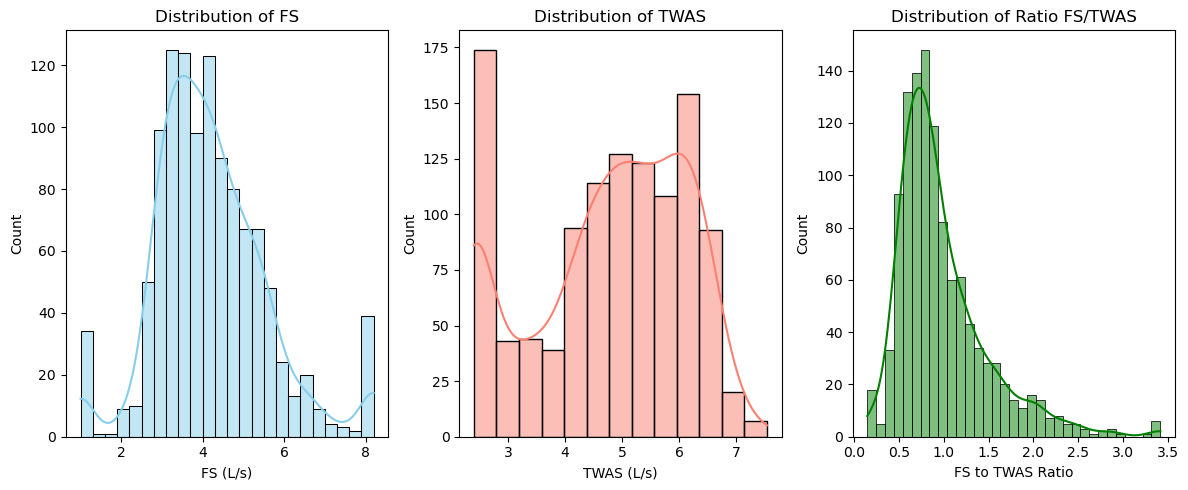

In [375]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.histplot(new_results_df_combined2['FS_flow'], kde=True, color='skyblue')
plt.title('Distribution of FS')
plt.xlabel('FS (L/s)')


plt.subplot(1, 3, 2)
sns.histplot(new_results_df_combined2['TWAS_flow'], kde=True, color='salmon')
plt.title('Distribution of TWAS')
plt.xlabel('TWAS (L/s)')


plt.subplot(1, 3, 3)
sns.histplot(new_results_df_combined2['FS_TWAS'], kde=True, color='green')
plt.title('Distribution of Ratio FS/TWAS')
plt.xticks(np.arange(0, 4, 0.5)) 
plt.xlabel('FS to TWAS Ratio')


plt.tight_layout()
plt.show()

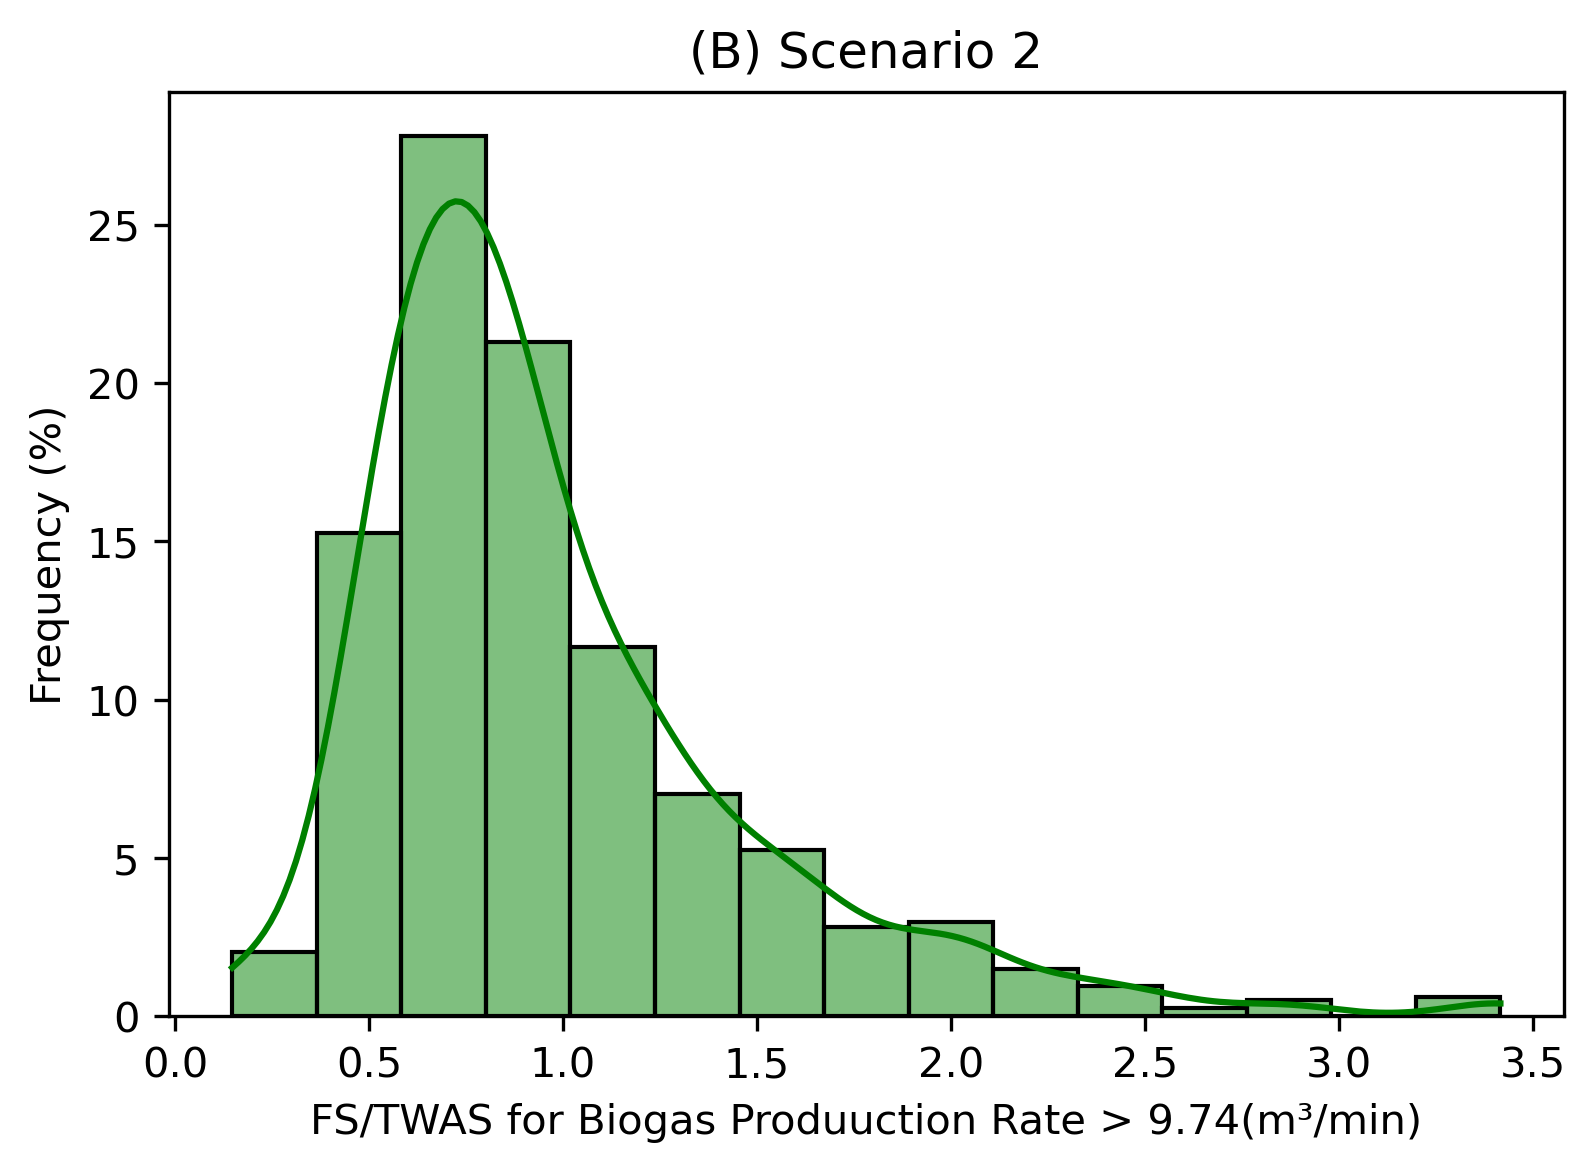

In [376]:
# Plot the histogram
# Increase figure size and set higher DPI
plt.figure(figsize=(6, 4), dpi=300)
sns.histplot(new_results_df_combined2['FS_TWAS'], bins=15, kde=True, color='g',  stat='percent')
plt.title('(B) Scenario 2')
plt.xlabel('FS/TWAS for Biogas Produuction Rate > 9.74(m\u00b3/min)')
plt.ylabel('Frequency (%)')
plt.grid(False)
plt.show()